## **Import Libraries**

In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Macro Factors**

### **US Data Extraction**

#### ADP

In [ ]:
# ADP 非农就业
df_non_agri = pd.read_excel('非农就业人数(月).xls', names=['Date','ADP non-agri'])  
df_non_agri

,Date,ADP non-agri
0,2000-02-29,131
1,2000-03-31,468
2,2000-04-30,287
3,2000-05-31,226
4,2000-06-30,-44
...,...,...
245,2020-07-31,1763
246,2020-08-31,1371
247,2020-09-30,661
248,2020-10-31,638


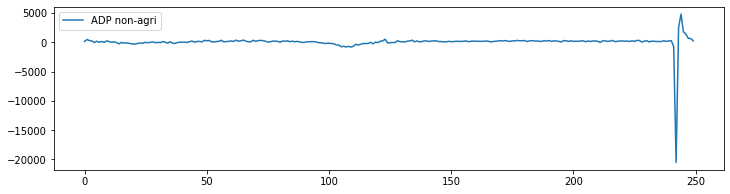

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_non_agri.shape[0]), np.array(df_non_agri.iloc[:,1]),label='ADP non-agri')
plt.legend()
plt.show()

#### US 企业债收益率

In [ ]:
df_Cor_bond = pd.read_excel('US企业债收益率(月).xls', names=['Date','US_Bond_return'])  
df_Cor_bond = df_Cor_bond.iloc[191:-1,:].reset_index().drop(["index"], axis = 1)
df_Cor_bond

,Date,US_Bond_return
0,2000-01-31,7.57
1,2000-02-29,7.76
2,2000-03-31,7.68
3,2000-04-30,7.57
4,2000-05-31,8.10
...,...,...
245,2020-06-30,0.97
246,2020-07-31,0.80
247,2020-08-31,0.71
248,2020-09-30,0.71


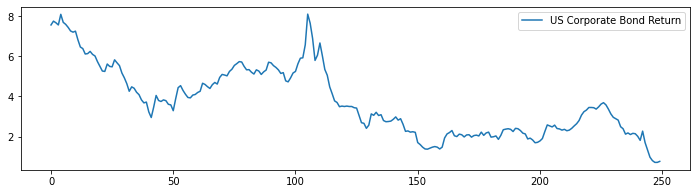

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_Cor_bond.shape[0]), np.array(df_Cor_bond.iloc[:,1]),label='US Corporate Bond Return')
plt.legend()
plt.show()

#### US 储备资产

In [ ]:
df_gov_asset = pd.read_excel('US储备资产(月).xls', names=['Date','US_gov_assets'])  
df_gov_asset = df_gov_asset.iloc[14:,:].reset_index().drop(["index"], axis = 1)
df_gov_asset

,Date,US_gov_assets
0,2000-01-31,69898
1,2000-02-29,69309
2,2000-03-31,70789
3,2000-04-30,66587
4,2000-05-31,67160
...,...,...
245,2020-06-30,133890
246,2020-07-31,139971
247,2020-08-31,140388
248,2020-09-30,138961


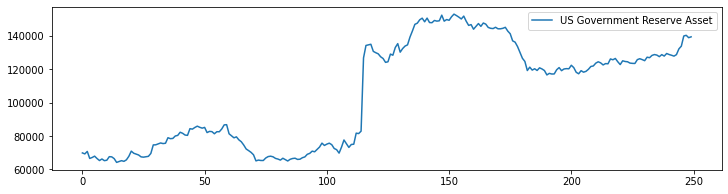

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_gov_asset.shape[0]), np.array(df_gov_asset.iloc[:,1]),label='US Government Reserve Asset')
plt.legend()
plt.show()

#### US 基准利率

In [ ]:
dates = df_gov_asset.Date.tolist()
df_us_base_rate = pd.read_excel('US基准利率.xls', names=['Date','US_base_rate'])  
df_us_base_rate['monthly_base_rate'] = df_us_base_rate['US_base_rate'].rolling(27, min_periods = 1).mean() 
df_us_base_rate = df_us_base_rate.iloc[::27,:]
df_us_base_rate = df_us_base_rate.iloc[15:-3,:].reset_index().drop(["index"],axis=1)
df_us_base_rate = df_us_base_rate.drop(["US_base_rate"],axis=1)
df_us_base_rate["Date"] = np.array(dates)
df_us_base_rate

,Date,monthly_base_rate
0,2000-01-31,5.791852
1,2000-02-29,5.487778
2,2000-03-31,5.225926
3,2000-04-30,4.714074
4,2000-05-31,4.197407
...,...,...
245,2020-06-30,1.338889
246,2020-07-31,0.081111
247,2020-08-31,0.048889
248,2020-09-30,0.080370


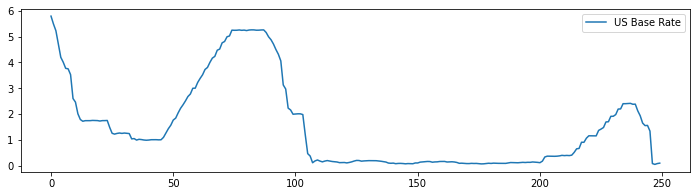

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_us_base_rate.shape[0]), np.array(df_us_base_rate.iloc[:,1]),label='US Base Rate')
plt.legend()
plt.show()

#### 外汇储备

In [ ]:
df_us_forei_res = pd.read_excel('US外汇储备(月).xls', names=['Date','US_foreign_asset_rev'])  
df_us_forei_res = df_us_forei_res.iloc[14:,:].reset_index().drop(["index"], axis = 1)
df_us_forei_res

,Date,US_foreign_asset_rev
0,2000-01-31,30941
1,2000-02-29,30406
2,2000-03-31,31535
3,2000-04-30,30014
4,2000-05-31,30429
...,...,...
245,2020-06-30,41662
246,2020-07-31,43247
247,2020-08-31,43506
248,2020-09-30,43052


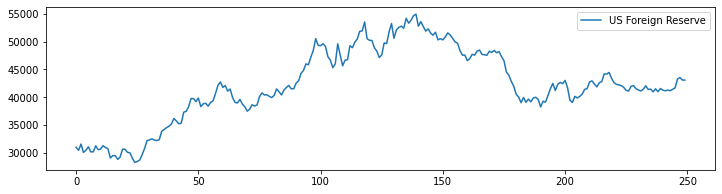

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_us_forei_res.shape[0]), np.array(df_us_forei_res.iloc[:,1]),label='US Foreign Reserve')
plt.legend()
plt.show()

#### US VIX

In [ ]:
dates = df_gov_asset.Date.tolist()
df_vix = pd.read_excel('US市场波动率指数(VIX).xls', names=['Date','VIX'])  
df_vix = df_vix.iloc[2524:,:].reset_index().drop(["index"], axis = 1)
df_vix['monthly_vix'] = df_vix['VIX'].rolling(21, min_periods = 1).mean() 
df_vix = df_vix.iloc[::21,:].reset_index().drop(["index"],axis=1)
df_vix = df_vix.iloc[:-2,:].drop(["VIX"],axis=1)
df_vix["Date"] = np.array(dates)
df_vix

,Date,monthly_vix
0,2000-01-31,24.210000
1,2000-02-29,23.161905
2,2000-03-31,23.202381
3,2000-04-30,23.078095
4,2000-05-31,27.528571
...,...,...
245,2020-06-30,29.077619
246,2020-07-31,31.226190
247,2020-08-31,24.514762
248,2020-09-30,25.249524


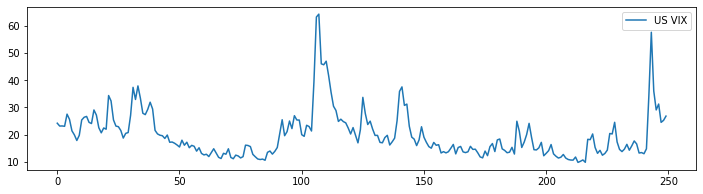

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_vix.shape[0]), np.array(df_vix.iloc[:,1]),label='US VIX')
plt.legend()
plt.show()

#### US 消费信贷

In [ ]:
df_us_com_cre = pd.read_excel('US消费信贷(月).xls', names=['Date','US_consumer_credit'])  
df_us_com_cre = df_us_com_cre.iloc[683:,:].reset_index().drop(["index"], axis = 1)
df_us_com_cre

,Date,US_consumer_credit
0,2000-01-31,1538520.18
1,2000-02-29,1549185.29
2,2000-03-31,1561450.69
3,2000-04-30,1570527.74
4,2000-05-31,1583507.92
...,...,...
245,2020-06-30,4137285.73
246,2020-07-31,4150494.02
247,2020-08-31,4141929.71
248,2020-09-30,4156963.53


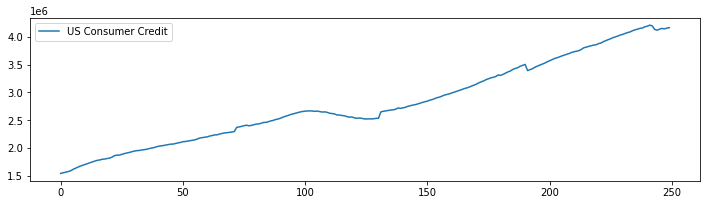

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_us_com_cre.shape[0]), np.array(df_us_com_cre.iloc[:,1]),label='US Consumer Credit')
plt.legend()
plt.show()

#### US CPI

In [ ]:
df_us_cpi = pd.read_excel('US消费者物价指数(CPI)同比(月).xls', names=['Date','US_CPI'])  
df_us_cpi = df_us_cpi.iloc[1031:-1,:].reset_index().drop(["index"], axis = 1)
df_us_cpi

,Date,US_CPI
0,2000-01-31,2.7
1,2000-02-29,3.2
2,2000-03-31,3.8
3,2000-04-30,3.1
4,2000-05-31,3.2
...,...,...
245,2020-06-30,0.6
246,2020-07-31,1.0
247,2020-08-31,1.3
248,2020-09-30,1.4


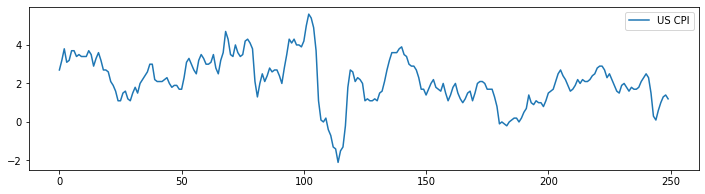

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_us_cpi.shape[0]), np.array(df_us_cpi.iloc[:,1]),label='US CPI')
plt.legend()
plt.show()

#### US政府赤字

In [ ]:
df_us_deficit = pd.read_excel('US联邦政府财政赤字(月).xls', names=['Date','US_gov_deficit'])  
df_us_deficit = df_us_deficit.iloc[230:-1,:].reset_index().drop(["index"], axis = 1)
df_us_deficit

,Date,US_gov_deficit
0,2000-01-31,-62152
1,2000-02-29,41734
2,2000-03-31,35380
3,2000-04-30,-159497
4,2000-05-31,3611
...,...,...
245,2020-06-30,864074
246,2020-07-31,62992
247,2020-08-31,200012
248,2020-09-30,124611


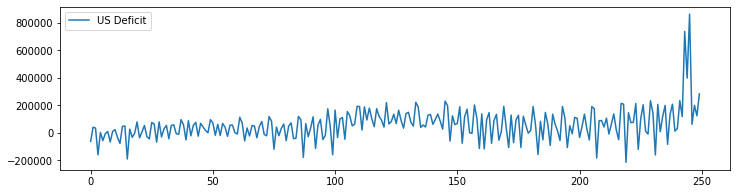

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_us_deficit.shape[0]), np.array(df_us_deficit.iloc[:,1]),label='US Deficit')
plt.legend()
plt.show()

#### US货币供应量

In [ ]:
df_us_money_supply = pd.read_excel('US货币供应量(月).xls', names=['Date','US_money_supply'])  
df_us_money_supply = df_us_money_supply.iloc[491:-1,:].reset_index().drop(["index"], axis = 1)
df_us_money_supply

,Date,US_money_supply
0,2000-01-31,1126.9
1,2000-02-29,1097.4
2,2000-03-31,1108.9
3,2000-04-30,1125.7
4,2000-05-31,1100.4
...,...,...
245,2020-06-30,5217.9
246,2020-07-31,5333.2
247,2020-08-31,5373.6
248,2020-09-30,5459.9


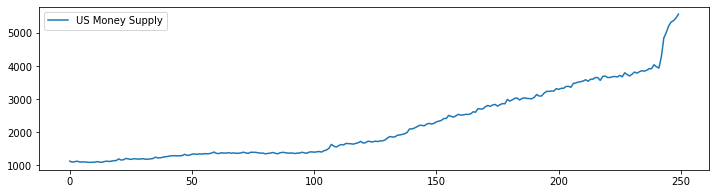

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_us_money_supply.shape[0]), np.array(df_us_money_supply.iloc[:,1]),label='US Money Supply')
plt.legend()
plt.show()

#### US 进口价格指数

In [ ]:
df_us_import_price_index = pd.read_excel('US进口价格指数(月).xls', names=['Date','import_price_index'])  
df_us_import_price_index = df_us_import_price_index.iloc[157:-1,:].reset_index().drop(["index"], axis = 1)
df_us_import_price_index

,Date,import_price_index
0,2000-01-31,97.8
1,2000-02-29,99.7
2,2000-03-31,99.9
3,2000-04-30,98.5
4,2000-05-31,98.8
...,...,...
245,2020-06-30,120.6
246,2020-07-31,122.1
247,2020-08-31,123.2
248,2020-09-30,123.4


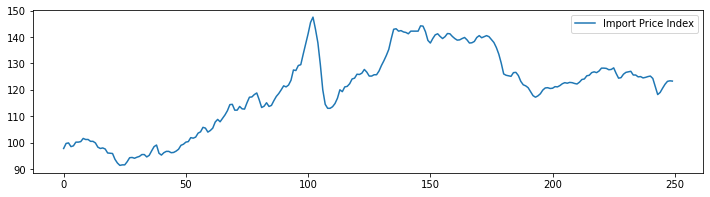

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_us_import_price_index.shape[0]), 
         np.array(df_us_import_price_index.iloc[:,1]),label='Import Price Index')
plt.legend()
plt.show()

#### US PMI

In [ ]:
df_us_pmi = pd.read_excel('US采购经理指数(PMI)(月).xls', names=['Date','US_pmi'])  
df_us_pmi = df_us_pmi.iloc[623:-1,:].reset_index().drop(["index"], axis = 1)
df_us_pmi

,Date,US_pmi
0,2000-01-31,56.7
1,2000-02-29,55.8
2,2000-03-31,54.9
3,2000-04-30,54.7
4,2000-05-31,53.2
...,...,...
245,2020-06-30,52.6
246,2020-07-31,54.2
247,2020-08-31,56.0
248,2020-09-30,55.4


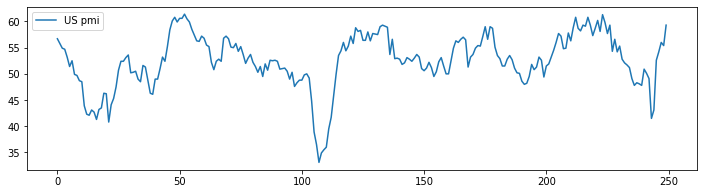

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_us_pmi.shape[0]), 
         np.array(df_us_pmi.iloc[:,1]),label='US pmi')
plt.legend()
plt.show()

#### Combine all date

In [ ]:
df_US = pd.concat([df_us_money_supply,df_Cor_bond, df_gov_asset,df_us_base_rate,
                   df_us_forei_res,df_vix,df_us_com_cre,df_us_cpi,df_us_deficit,
                   df_us_pmi,df_us_import_price_index, df_non_agri], 
                  axis=1).drop(["Date"], axis =1) 
df_US.insert(loc=0, column='Date', value=dates)
df_US

,Date,US_money_supply,US_Bond_return,US_gov_assets,monthly_base_rate,US_foreign_asset_rev,monthly_vix,US_consumer_credit,US_CPI,US_gov_deficit,US_pmi,import_price_index,ADP non-agri
0,2000-01-31,1126.9,7.57,69898,5.791852,30941,24.210000,1538520.18,2.7,-62152,56.7,97.8,131
1,2000-02-29,1097.4,7.76,69309,5.487778,30406,23.161905,1549185.29,3.2,41734,55.8,99.7,468
2,2000-03-31,1108.9,7.68,70789,5.225926,31535,23.202381,1561450.69,3.8,35380,54.9,99.9,287
3,2000-04-30,1125.7,7.57,66587,4.714074,30014,23.078095,1570527.74,3.1,-159497,54.7,98.5,226
4,2000-05-31,1100.4,8.10,67160,4.197407,30429,27.528571,1583507.92,3.2,3611,53.2,98.8,-44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020-06-30,5217.9,0.97,133890,1.338889,41662,29.077619,4137285.73,0.6,864074,52.6,120.6,1763
246,2020-07-31,5333.2,0.80,139971,0.081111,43247,31.226190,4150494.02,1.0,62992,54.2,122.1,1371
247,2020-08-31,5373.6,0.71,140388,0.048889,43506,24.514762,4141929.71,1.3,200012,56.0,123.2,661
248,2020-09-30,5459.9,0.71,138961,0.080370,43052,25.249524,4156963.53,1.4,124611,55.4,123.4,638


### **China Data Extraction**

#### M0 供应量

In [ ]:
# ADP 就业数据
df_M0 = pd.read_excel('M0供应量(月).xls', names=['Date','M0'])  
df_M0 = df_M0[65:-1].reset_index().drop(["index"], axis = 1)
df_M0

,Date,M0
0,2000-01-31,16094.00
1,2000-02-29,13983.00
2,2000-03-31,13235.00
3,2000-04-30,13676.00
4,2000-05-31,13075.00
...,...,...
245,2020-06-30,79459.41
246,2020-07-31,79867.21
247,2020-08-31,80042.71
248,2020-09-30,82370.87


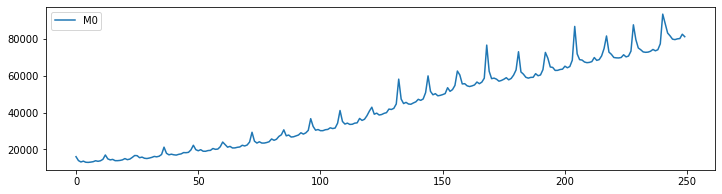

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_M0.shape[0]), 
         np.array(df_M0.iloc[:,1]),label='M0')
plt.legend()
plt.show()

#### 中国CPI

In [ ]:
df_Chinese_CPI = pd.read_excel('中国CPI当月同比(月).xls', names=['Date','Chinese CPI'])  
df_Chinese_CPI = df_Chinese_CPI.iloc[155:-1,:].reset_index().drop(["index"], axis = 1)
df_Chinese_CPI

,Date,Chinese CPI
0,2000-01-31,-0.2
1,2000-02-29,0.7
2,2000-03-31,-0.2
3,2000-04-30,-0.3
4,2000-05-31,0.1
...,...,...
245,2020-06-30,2.5
246,2020-07-31,2.7
247,2020-08-31,2.4
248,2020-09-30,1.7


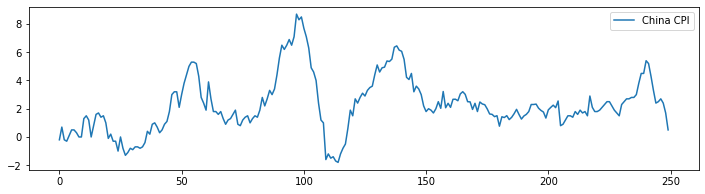

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_Chinese_CPI.shape[0]), 
         np.array(df_Chinese_CPI.iloc[:,1]),label='China CPI')
plt.legend()
plt.show()

#### 中国投资海外证券情况

In [ ]:
df_oversea_inv = pd.read_excel('中国投资海外证券情况(月).xls', names=['Date','CHN_oversea_sec_inv'])  
df_oversea_inv = df_oversea_inv.iloc[252:,:].reset_index().drop(["index"], axis = 1)
df_oversea_inv

,Date,CHN_oversea_sec_inv
0,2000-01-31,11436
1,2000-02-29,8446
2,2000-03-31,4667
3,2000-04-30,3928
4,2000-05-31,7576
...,...,...
245,2020-06-30,14039
246,2020-07-31,19726
247,2020-08-31,24986
248,2020-09-30,17454


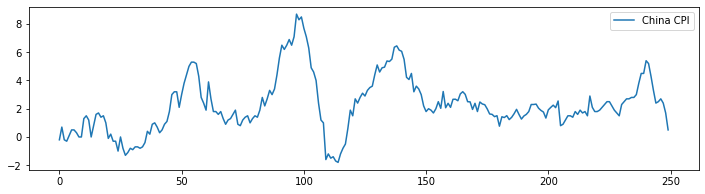

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_Chinese_CPI.shape[0]), 
         np.array(df_Chinese_CPI.iloc[:,1]),label='China CPI')
plt.legend()
plt.show()

#### 当月规模以上工业增加值

In [ ]:
df_industry_increment = pd.read_excel('规模以上工业增加值当月(月).xls', names=['Date','increment from scaled industry'])  
df_industry_increment = df_industry_increment.iloc[119:-1,:].reset_index().drop(["index"], axis = 1)
df_industry_increment

,Date,increment from scaled industry
0,2000-01-31,8.9
1,2000-02-29,12.0
2,2000-03-31,11.9
3,2000-04-30,11.4
4,2000-05-31,11.5
...,...,...
245,2020-06-30,4.8
246,2020-07-31,4.8
247,2020-08-31,5.6
248,2020-09-30,6.9


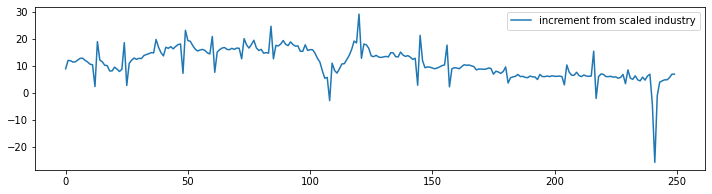

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_industry_increment.shape[0]), 
         np.array(df_industry_increment.iloc[:,1]),label='increment from scaled industry')
plt.legend()
plt.show()

#### 宏观经济景气指数

In [ ]:
df_mac_eco_index = pd.read_excel('宏观经济景气指数(月).xls', names=['Date','macro eco performance index'])  
df_mac_eco_index = df_mac_eco_index.iloc[106:,:].reset_index().drop(["index"], axis = 1)
df_mac_eco_index

,Date,macro eco performance index
0,1999-12-31,100.6400
1,2000-01-31,101.1800
2,2000-02-29,100.9400
3,2000-03-31,101.0000
4,2000-04-30,100.4000
...,...,...
245,2020-05-31,100.4113
246,2020-06-30,102.1435
247,2020-07-31,103.4623
248,2020-08-31,104.5291


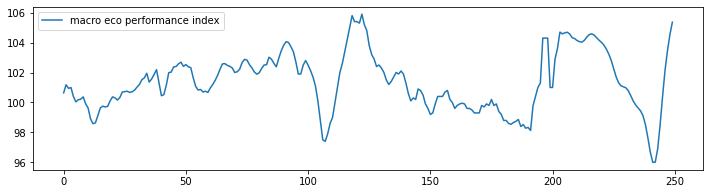

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_mac_eco_index.shape[0]), 
         np.array(df_mac_eco_index.iloc[:,1]),label='macro eco performance index')
plt.legend()
plt.show()

#### 中国出口价格指数

In [ ]:
df_CNY_import_index = pd.read_excel('出口价格指数HS2分类(月).xls', names=['Date','CNY HS2 import index'])  
df_CNY_import_index = df_CNY_import_index.iloc[81:,:].reset_index().drop(["index"], axis = 1)
df_CNY_import_index["Date"] = np.array(dates)
df_CNY_import_index

,Date,CNY HS2 import index
0,2000-01-31,100.3
1,2000-02-29,100.6
2,2000-03-31,99.8
3,2000-04-30,99.7
4,2000-05-31,101.8
...,...,...
245,2020-06-30,108.4
246,2020-07-31,104.3
247,2020-08-31,104.3
248,2020-09-30,101.3


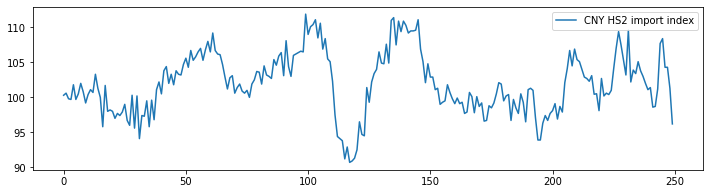

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_CNY_import_index.shape[0]), 
         np.array(df_CNY_import_index.iloc[:,1]),label='CNY HS2 import index')
plt.legend()
plt.show()

#### 人民币存款基准利率

In [ ]:
df_CNY_saving_base = pd.read_excel('人民币存款基准利率.xls', names=['Date','CNY Saving Account Base Rate'])  
df_CNY_saving_base = df_CNY_saving_base.iloc[131:,:].reset_index().drop(["index"], axis = 1)
df_CNY_saving_base["Date"] = np.array(dates)
df_CNY_saving_base

,Date,CNY Saving Account Base Rate
0,2000-01-31,0.99
1,2000-02-29,0.99
2,2000-03-31,0.99
3,2000-04-30,0.99
4,2000-05-31,0.99
...,...,...
245,2020-06-30,0.35
246,2020-07-31,0.35
247,2020-08-31,0.35
248,2020-09-30,0.35


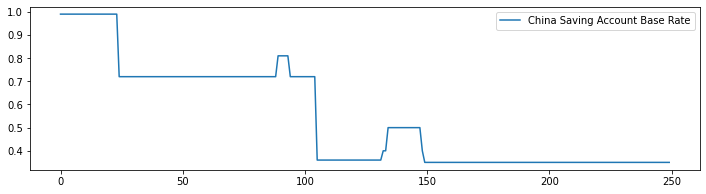

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_CNY_saving_base.shape[0]), 
         np.array(df_CNY_saving_base.iloc[:,1]),label='China Saving Account Base Rate')
plt.legend()
plt.show()

#### 国家财政支出

In [ ]:
df_fiscal = pd.read_excel('国家财政支出(月).xls', names=['Date','Government Fiscal Spending'])  
df_fiscal = df_fiscal.iloc[117:,:].reset_index().drop(["index"], axis = 1)
df_fiscal["Date"] = np.array(dates)
df_fiscal

,Date,Government Fiscal Spending
0,2000-01-31,1118.33
1,2000-02-29,3315.88
2,2000-03-31,776.57
3,2000-04-30,718.16
4,2000-05-31,878.69
...,...,...
245,2020-06-30,17088.00
246,2020-07-31,16426.00
247,2020-08-31,25260.00
248,2020-09-30,14254.00


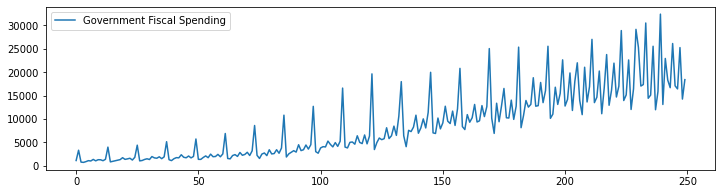

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_fiscal.shape[0]), 
         np.array(df_fiscal.iloc[:,1]),label='Government Fiscal Spending')
plt.legend()
plt.show()

#### 官方外汇储备

In [ ]:
df_CNY_foreign_res = pd.read_excel('官方外汇储备(月).xls', names=['Date','Official Foreign Asset Reserve'])  
df_CNY_foreign_res = df_CNY_foreign_res.iloc[126:-1,:].reset_index().drop(["index"], axis = 1)
df_CNY_foreign_res

,Date,Official Foreign Asset Reserve
0,2000-01-31,1561.00
1,2000-02-29,1565.59
2,2000-03-31,1568.20
3,2000-04-30,1568.46
4,2000-05-31,1580.19
...,...,...
245,2020-06-30,31123.28
246,2020-07-31,31543.91
247,2020-08-31,31646.09
248,2020-09-30,31425.62


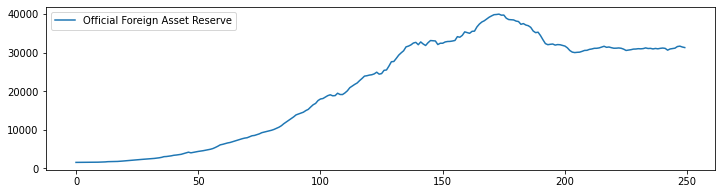

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_CNY_foreign_res.shape[0]), 
         np.array(df_CNY_foreign_res.iloc[:,1]),label='Official Foreign Asset Reserve')
plt.legend()
plt.show()

#### 金融机构存款准备金率

In [ ]:
df_deposit_reserve_ratio = pd.read_excel('金融机构存款准备金率.xls', names=['Date','Financial Institute Required Reserve Ratio'])  
df_deposit_reserve_ratio = df_deposit_reserve_ratio.iloc[179:-1,:].reset_index().drop(["index"], axis = 1)
df_deposit_reserve_ratio

,Date,Financial Institute Required Reserve Ratio
0,2000-01-31,6.0
1,2000-02-29,6.0
2,2000-03-31,6.0
3,2000-04-30,6.0
4,2000-05-31,6.0
...,...,...
245,2020-06-30,12.5
246,2020-07-31,12.5
247,2020-08-31,12.5
248,2020-09-30,12.5


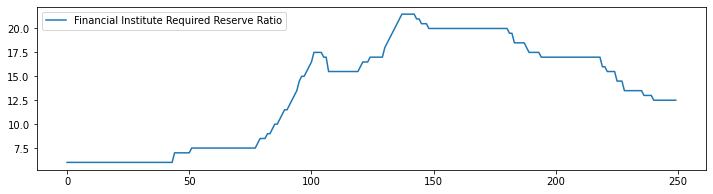

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_deposit_reserve_ratio.shape[0]), 
         np.array(df_deposit_reserve_ratio.iloc[:,1]),
         label='Financial Institute Required Reserve Ratio')
plt.legend()
plt.show()

#### 消费者信心指数

In [ ]:
df_consumer_confi_index = pd.read_excel('消费者信心指数.xls', names=['Date','Consumer Confidence Index'])  
df_consumer_confi_index = df_consumer_confi_index.iloc[107:,:].reset_index().drop(["index"], axis = 1)
df_consumer_confi_index

,Date,Consumer Confidence Index
0,2000-01-31,109.7
1,2000-02-29,110.0
2,2000-03-31,110.4
3,2000-04-30,110.6
4,2000-05-31,111.1
...,...,...
245,2020-06-30,112.6
246,2020-07-31,117.2
247,2020-08-31,116.4
248,2020-09-30,120.5


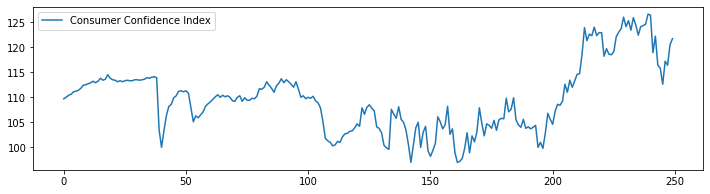

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_consumer_confi_index.shape[0]), 
         np.array(df_consumer_confi_index.iloc[:,1]),
         label='Consumer Confidence Index')
plt.legend()
plt.show()

#### Combine all date

In [ ]:
df_China = pd.concat([df_M0,df_Chinese_CPI,df_oversea_inv,df_industry_increment,
                      df_mac_eco_index,df_CNY_import_index,df_CNY_saving_base,
                      df_fiscal,df_deposit_reserve_ratio,df_CNY_foreign_res,
                      df_consumer_confi_index],axis=1).drop(["Date"], axis =1) 
                      
df_China.insert(loc=0, column='Date', value=dates)
df_China = df_China.reset_index().drop(["index"], axis = 1)

In [ ]:
df_China

,Date,M0,Chinese CPI,CHN_oversea_sec_inv,increment from scaled industry,macro eco performance index,CNY HS2 import index,CNY Saving Account Base Rate,Government Fiscal Spending,Financial Institute Required Reserve Ratio,Official Foreign Asset Reserve,Consumer Confidence Index
0,2000-01-31,16094.00,-0.2,11436,8.9,100.6400,100.3,0.99,1118.33,6.0,1561.00,109.7
1,2000-02-29,13983.00,0.7,8446,12.0,101.1800,100.6,0.99,3315.88,6.0,1565.59,110.0
2,2000-03-31,13235.00,-0.2,4667,11.9,100.9400,99.8,0.99,776.57,6.0,1568.20,110.4
3,2000-04-30,13676.00,-0.3,3928,11.4,101.0000,99.7,0.99,718.16,6.0,1568.46,110.6
4,2000-05-31,13075.00,0.1,7576,11.5,100.4000,101.8,0.99,878.69,6.0,1580.19,111.1
...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020-06-30,79459.41,2.5,14039,4.8,100.4113,108.4,0.35,17088.00,12.5,31123.28,112.6
246,2020-07-31,79867.21,2.7,19726,4.8,102.1435,104.3,0.35,16426.00,12.5,31543.91,117.2
247,2020-08-31,80042.71,2.4,24986,5.6,103.4623,104.3,0.35,25260.00,12.5,31646.09,116.4
248,2020-09-30,82370.87,1.7,17454,6.9,104.5291,101.3,0.35,14254.00,12.5,31425.62,120.5


### **Combine China and US data**

In [ ]:
df_all = pd.concat([df_US, df_China], axis=1).drop(["Date"], axis =1)

In [ ]:
df_all

,US_money_supply,US_Bond_return,US_gov_assets,monthly_base_rate,US_foreign_asset_rev,monthly_vix,US_consumer_credit,US_CPI,US_gov_deficit,US_pmi,import_price_index,ADP non-agri,M0,Chinese CPI,CHN_oversea_sec_inv,increment from scaled industry,macro eco performance index,CNY HS2 import index,CNY Saving Account Base Rate,Government Fiscal Spending,Financial Institute Required Reserve Ratio,Official Foreign Asset Reserve,Consumer Confidence Index
0,1126.9,7.57,69898,5.791852,30941,24.210000,1538520.18,2.7,-62152,56.7,97.8,131,16094.00,-0.2,11436,8.9,100.6400,100.3,0.99,1118.33,6.0,1561.00,109.7
1,1097.4,7.76,69309,5.487778,30406,23.161905,1549185.29,3.2,41734,55.8,99.7,468,13983.00,0.7,8446,12.0,101.1800,100.6,0.99,3315.88,6.0,1565.59,110.0
2,1108.9,7.68,70789,5.225926,31535,23.202381,1561450.69,3.8,35380,54.9,99.9,287,13235.00,-0.2,4667,11.9,100.9400,99.8,0.99,776.57,6.0,1568.20,110.4
3,1125.7,7.57,66587,4.714074,30014,23.078095,1570527.74,3.1,-159497,54.7,98.5,226,13676.00,-0.3,3928,11.4,101.0000,99.7,0.99,718.16,6.0,1568.46,110.6
4,1100.4,8.10,67160,4.197407,30429,27.528571,1583507.92,3.2,3611,53.2,98.8,-44,13075.00,0.1,7576,11.5,100.4000,101.8,0.99,878.69,6.0,1580.19,111.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,5217.9,0.97,133890,1.338889,41662,29.077619,4137285.73,0.6,864074,52.6,120.6,1763,79459.41,2.5,14039,4.8,100.4113,108.4,0.35,17088.00,12.5,31123.28,112.6
246,5333.2,0.80,139971,0.081111,43247,31.226190,4150494.02,1.0,62992,54.2,122.1,1371,79867.21,2.7,19726,4.8,102.1435,104.3,0.35,16426.00,12.5,31543.91,117.2
247,5373.6,0.71,140388,0.048889,43506,24.514762,4141929.71,1.3,200012,56.0,123.2,661,80042.71,2.4,24986,5.6,103.4623,104.3,0.35,25260.00,12.5,31646.09,116.4
248,5459.9,0.71,138961,0.080370,43052,25.249524,4156963.53,1.4,124611,55.4,123.4,638,82370.87,1.7,17454,6.9,104.5291,101.3,0.35,14254.00,12.5,31425.62,120.5


### **Targets: USD/CNY Exchange Rate**

In [ ]:
# read USD/CNY average rate
df_fx = pd.read_excel('USDCNY平均汇率(月).xls', names=['Date','USD/CNY'])  
df_fx = df_fx.iloc[119:-1,:]

In [ ]:
# read the data
df_fx

,Date,USD/CNY
119,2000-01-31,8.2791
120,2000-02-29,8.2779
121,2000-03-31,8.2785
122,2000-04-30,8.2793
123,2000-05-31,8.2775
...,...,...
364,2020-06-30,7.0867
365,2020-07-31,7.0088
366,2020-08-31,6.9346
367,2020-09-30,6.8148


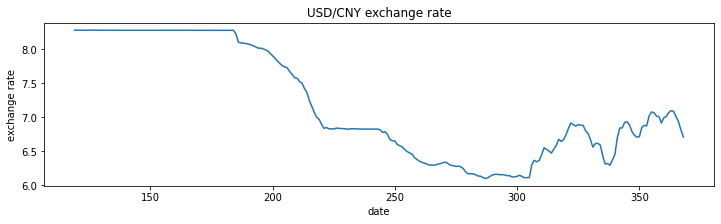

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(df_fx['USD/CNY'])
plt.xlabel('date')
plt.ylabel('exchange rate')
plt.title('USD/CNY exchange rate')
plt.show()

In [ ]:
# moving average calculation
df_fx['daily_dif'] = df_fx['USD/CNY'].diff(periods=1) # daily increase
df_fx['SMA_7_ON'] = df_fx['USD/CNY'].rolling(7, min_periods = 1).mean() # weekly simple moving average
df_fx['SMA_30_ON'] = df_fx['USD/CNY'].rolling(30, min_periods = 1).mean() # monthly simple moving average
df_fx['CMA'] = df_fx['USD/CNY'].expanding().mean() # cumulative moving average
df_fx['EMA_0.3'] = df_fx['USD/CNY'].ewm(alpha = 0.3, adjust = False).mean() # exponential moving average, alpha of 0.3
df_fx['EMA_0.1'] = df_fx['USD/CNY'].ewm(alpha = 0.1, adjust = False).mean() # exponential moving average, alpha of 0.1

In [ ]:
df_fx = df_fx.reset_index().drop(["index"], axis=1)
df_fx

,Date,USD/CNY,daily_dif,SMA_7_ON,SMA_30_ON,CMA,EMA_0.3,EMA_0.1
0,2000-01-31,8.2791,NaN,8.279100,8.279100,8.279100,8.279100,8.279100
1,2000-02-29,8.2779,-0.0012,8.278500,8.278500,8.278500,8.278740,8.278980
2,2000-03-31,8.2785,0.0006,8.278500,8.278500,8.278500,8.278668,8.278932
3,2000-04-30,8.2793,0.0008,8.278700,8.278700,8.278700,8.278858,8.278969
4,2000-05-31,8.2775,-0.0018,8.278460,8.278460,8.278460,8.278450,8.278822
...,...,...,...,...,...,...,...,...
245,2020-06-30,7.0867,-0.0119,7.026871,6.809250,7.193490,7.053190,6.948086
246,2020-07-31,7.0088,-0.0779,7.026300,6.828330,7.192743,7.039873,6.954158
247,2020-08-31,6.9346,-0.0742,7.028786,6.848943,7.191702,7.008291,6.952202
248,2020-09-30,6.8148,-0.1198,7.003429,6.865370,7.190188,6.950244,6.938462


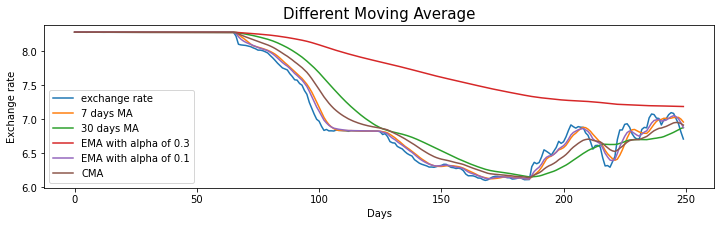

In [ ]:
plt.figure(figsize = (12,3))

# number of plot
num_data = np.arange(0, df_fx.shape[0],step=1)

# plot for all kinds of moving average
plt.plot(num_data, df_fx['USD/CNY'],label='exchange rate')
plt.plot(num_data, df_fx['SMA_7_ON'],label='7 days MA')
plt.plot(num_data, df_fx['SMA_30_ON'],label='30 days MA')
plt.plot(num_data, df_fx['CMA'],label='EMA with alpha of 0.3')
plt.plot(num_data, df_fx['EMA_0.3'],label='EMA with alpha of 0.1')
plt.plot(num_data, df_fx['EMA_0.1'], label='CMA')
plt.xlabel('Days',size = 10)
plt.ylabel('Exchange rate',size = 10)
plt.legend()
plt.title('Different Moving Average',size = 15)
plt.show()

### **Final Dataset**

In [ ]:
ds = pd.concat([df_fx[["USD/CNY"]], df_all], axis=1)

In [ ]:
ds

,USD/CNY,US_money_supply,US_Bond_return,US_gov_assets,monthly_base_rate,US_foreign_asset_rev,monthly_vix,US_consumer_credit,US_CPI,US_gov_deficit,US_pmi,import_price_index,ADP non-agri,M0,Chinese CPI,CHN_oversea_sec_inv,increment from scaled industry,macro eco performance index,CNY HS2 import index,CNY Saving Account Base Rate,Government Fiscal Spending,Financial Institute Required Reserve Ratio,Official Foreign Asset Reserve,Consumer Confidence Index
0,8.2791,1126.9,7.57,69898,5.791852,30941,24.210000,1538520.18,2.7,-62152,56.7,97.8,131,16094.00,-0.2,11436,8.9,100.6400,100.3,0.99,1118.33,6.0,1561.00,109.7
1,8.2779,1097.4,7.76,69309,5.487778,30406,23.161905,1549185.29,3.2,41734,55.8,99.7,468,13983.00,0.7,8446,12.0,101.1800,100.6,0.99,3315.88,6.0,1565.59,110.0
2,8.2785,1108.9,7.68,70789,5.225926,31535,23.202381,1561450.69,3.8,35380,54.9,99.9,287,13235.00,-0.2,4667,11.9,100.9400,99.8,0.99,776.57,6.0,1568.20,110.4
3,8.2793,1125.7,7.57,66587,4.714074,30014,23.078095,1570527.74,3.1,-159497,54.7,98.5,226,13676.00,-0.3,3928,11.4,101.0000,99.7,0.99,718.16,6.0,1568.46,110.6
4,8.2775,1100.4,8.10,67160,4.197407,30429,27.528571,1583507.92,3.2,3611,53.2,98.8,-44,13075.00,0.1,7576,11.5,100.4000,101.8,0.99,878.69,6.0,1580.19,111.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,7.0867,5217.9,0.97,133890,1.338889,41662,29.077619,4137285.73,0.6,864074,52.6,120.6,1763,79459.41,2.5,14039,4.8,100.4113,108.4,0.35,17088.00,12.5,31123.28,112.6
246,7.0088,5333.2,0.80,139971,0.081111,43247,31.226190,4150494.02,1.0,62992,54.2,122.1,1371,79867.21,2.7,19726,4.8,102.1435,104.3,0.35,16426.00,12.5,31543.91,117.2
247,6.9346,5373.6,0.71,140388,0.048889,43506,24.514762,4141929.71,1.3,200012,56.0,123.2,661,80042.71,2.4,24986,5.6,103.4623,104.3,0.35,25260.00,12.5,31646.09,116.4
248,6.8148,5459.9,0.71,138961,0.080370,43052,25.249524,4156963.53,1.4,124611,55.4,123.4,638,82370.87,1.7,17454,6.9,104.5291,101.3,0.35,14254.00,12.5,31425.62,120.5


In [ ]:
# Splitting the dataset into train & test subsets
n_obs = 200
df_train, df_test = ds[:n_obs], ds[n_obs:]

### **Forecasting Model**

#### Check for stationality

In [ ]:
# Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
def adf_test(ds):
    dftest = adfuller(ds, autolag='AIC')   # one that has minimum AIC among all the other models
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")

#### First Order Differencing

In [ ]:
for i in df_train.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_train[i])
    print('\n')

# Differencing all variables to get rid of Stationarity
ds_differenced = df_train.diff().dropna()

Column:  USD/CNY
--------------------------------------
Test Statistic           -1.252911
p-value                   0.650431
# Lags                    5.000000
# Observations          194.000000
Critical Value (1%)      -3.464515
Critical Value (5%)      -2.876556
Critical Value (10%)     -2.574775
dtype: float64

Series is Non-Stationary


Column:  US_money_supply
--------------------------------------
Test Statistic            1.481435
p-value                   0.997454
# Lags                   12.000000
# Observations          187.000000
Critical Value (1%)      -3.465812
Critical Value (5%)      -2.877123
Critical Value (10%)     -2.575077
dtype: float64

Series is Non-Stationary


Column:  US_Bond_return
--------------------------------------
Test Statistic           -1.757370
p-value                   0.401822
# Lags                    2.000000
# Observations          197.000000
Critical Value (1%)      -3.463987
Critical Value (5%)      -2.876326
Critical Value (10%)     -2.574

#### Second Order Differencing

In [ ]:
# Running the ADF test once again to test for Stationarity
for i in ds_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(ds_differenced[i])
    print('\n')

# Some features are non-stationary
ds_differenced = ds_differenced.diff().dropna()

Column:  USD/CNY
--------------------------------------
Test Statistic           -2.799064
p-value                   0.058408
# Lags                    4.000000
# Observations          194.000000
Critical Value (1%)      -3.464515
Critical Value (5%)      -2.876556
Critical Value (10%)     -2.574775
dtype: float64

Series is Non-Stationary


Column:  US_money_supply
--------------------------------------
Test Statistic           -1.821570
p-value                   0.369807
# Lags                   11.000000
# Observations          187.000000
Critical Value (1%)      -3.465812
Critical Value (5%)      -2.877123
Critical Value (10%)     -2.575077
dtype: float64

Series is Non-Stationary


Column:  US_Bond_return
--------------------------------------
Test Statistic         -1.026374e+01
p-value                 4.171224e-18
# Lags                  1.000000e+00
# Observations          1.970000e+02
Critical Value (1%)    -3.463987e+00
Critical Value (5%)    -2.876326e+00
Critical Value (10%

#### Third Order Differencing (not used to avoid over-differencing)

In [ ]:
# Running the ADF test for the 3rd time to test for Stationarity
#for i in ds_differenced.columns:
#    print("Column: ",i)
#    print('--------------------------------------')
#    adf_test(ds_differenced[i])
#    print('\n')

**Three times differencing to achieve stationary for all the data. However, only 2 order of differencing is used to avoid over differencing.**

#### **VAR model**

In [ ]:
# Fitting the VAR model to the 2nd Differenced Data
model = VAR(ds_differenced)
results = model.fit(maxlags = 5, ic = 'aic')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Jan, 2021
Time:                     08:38:14
--------------------------------------------------------------------
No. of Equations:         24.0000    BIC:                    175.153
Nobs:                     193.000    HQIC:                   145.941
Log likelihood:          -15833.4    FPE:                1.06754e+57
AIC:                      126.061    Det(Omega_mle):     9.02501e+51
--------------------------------------------------------------------
Results for equation USD/CNY
                                                   coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------------
const                                                 0.000283         0.001670            0.170           0.865
L1.USD/CNY                                 

In [ ]:
# Forecasting for the rest 50 steps ahead
predicted = results.forecast(ds_differenced.values[:200], 50)
forecast = pd.DataFrame(predicted, index = ds.index[:50], columns = ds.columns)

In [ ]:
# Inverting the Differencing Transformation
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [ ]:
forecast_values = invert_transformation(df_train, forecast, second_diff=True)

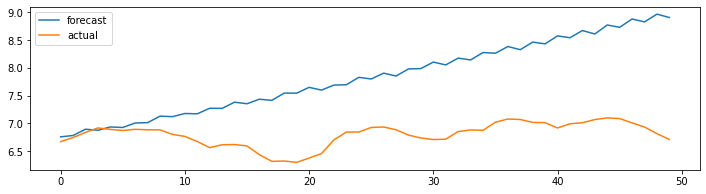

In [ ]:
# Actual vs Forecasted Plots
plt.figure(figsize = (12,3))
plt.plot(np.arange(50), np.array(forecast_values["USD/CNY"]),label='forecast')
plt.plot(np.arange(50), np.array(ds["USD/CNY"].iloc[-50:]),label='actual')
plt.legend()
plt.show()

In [ ]:
y_valid = np.array(forecast_values["USD/CNY"])
preds = np.array(ds["USD/CNY"].iloc[-50:])
SMAPE = (100/len(y_valid)) * np.sum(2 * np.abs(preds - y_valid) / (np.abs(y_valid) + np.abs(preds)))
print("the symmetric mean absolute percentage error is", round(SMAPE,3),"%")

the symmetric mean absolute percentage error is 13.697 %


In [ ]:
# feature importance
X = ds.iloc[:,1:]
y = ds.iloc[:,0]
X_std = MinMaxScaler().fit_transform(X) # scaling based on range for different features 
 
clf = RandomForestRegressor(random_state = 0, n_jobs = -1)
predictor = clf.fit(X_std, y)
feature_importance = predictor.feature_importances_ # feature importance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

<BarContainer object of 23 artists>

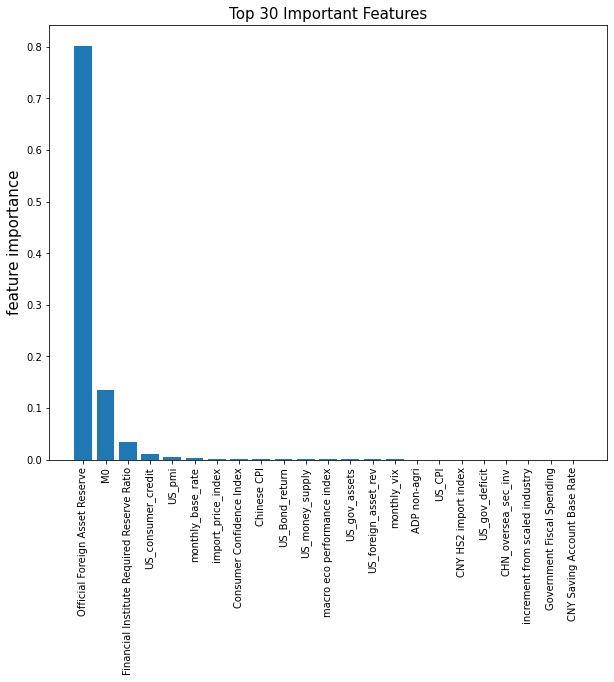

In [ ]:
Feature_name = X.columns
indices = feature_importance.argsort()[::-1][0:30]
feature_importance [[indices]]
Feature_name[[indices]]

plt.figure(figsize=(10,8))
plt.title('Top 30 Important Features',fontsize = 15)
plt.ylabel('feature importance',fontsize = 15)
plt.xticks(rotation = 90)
plt.bar(Feature_name[[indices]],feature_importance[[indices]])

#### **Decison Trees**

In [ ]:
x_train, y_train = np.array(df_train.iloc[:,1:]), np.array(df_train.iloc[:,0])
x_test, y_test = np.array(df_test.iloc[:,1:]), np.array(df_test.iloc[:,0])

In [ ]:
DS = DecisionTreeRegressor()
criterion = ['mse','mae',"poisson"]
max_depth = [25,50,100,200,1000]
splitter = ['best', 'random']
param_grid = dict(criterion = criterion, max_depth = max_depth, splitter = splitter)
grid = GridSearchCV(estimator = DS, param_grid = param_grid, scoring = 'neg_mean_absolute_error', verbose = 0, n_jobs = -1, cv = 5)

In [ ]:
result = grid.fit(x_train,y_train)
print('best score:', result.best_score_)
print('best parameters:', result.best_params_)

best score: -0.17257050000000002
best parameters: {'criterion': 'mae', 'max_depth': 1000, 'splitter': 'random'}


In [ ]:
final_DS = DecisionTreeRegressor(criterion = "mse", max_depth = 100, splitter='random').fit(x_train,y_train)
DS_pre = final_DS.predict(x_test)

In [ ]:
y_valid = y_test
preds = final_DS.predict(x_test)
SMAPE = (100/len(y_valid)) * np.sum(2 * np.abs(preds - y_valid) / (np.abs(y_valid) + np.abs(preds)))
print("the symmetric mean absolute percentage error is", round(SMAPE,3),"%")

the symmetric mean absolute percentage error is 4.244 %


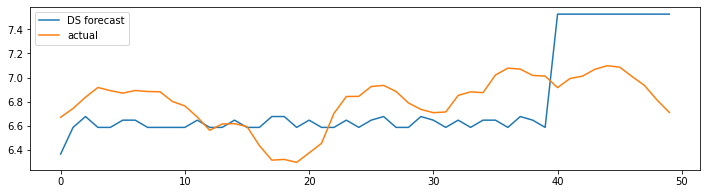

In [ ]:
# Decision Tree Forecasted vs Acutal Plots
plt.figure(figsize = (12,3))
plt.plot(np.arange(50), DS_pre, label='DS forecast')
plt.plot(np.arange(50), y_test,label='actual')
plt.legend()
plt.show()

In [ ]:
X = ds.iloc[:,1:]
y = ds.iloc[:,0]

#scaling based on range for different features 
X_std = MinMaxScaler().fit_transform(X) 
 
clf = DecisionTreeRegressor(criterion = "mse", max_depth = 25, splitter='random')
predictor = clf.fit(X_std, y)

# feature importance
feature_importance = predictor.feature_importances_ 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

<BarContainer object of 23 artists>

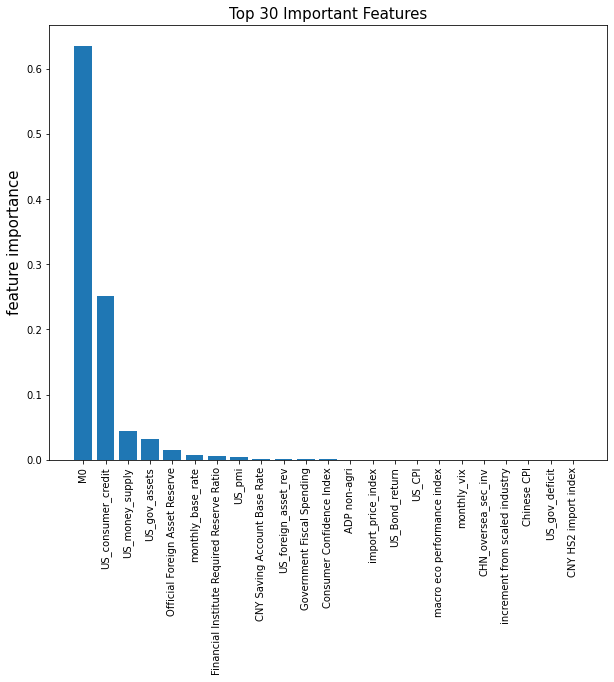

In [ ]:
Feature_name = X.columns
indices = feature_importance.argsort()[::-1][0:30]
feature_importance [[indices]]
Feature_name[[indices]]

plt.figure(figsize=(10,8))
plt.title('Top 30 Important Features',fontsize = 15)
plt.ylabel('feature importance',fontsize = 15)
plt.xticks(rotation = 90)
plt.bar(Feature_name[[indices]],feature_importance[[indices]])

#### **Random Forest**

In [ ]:
x_train, y_train = np.array(df_train.iloc[:,1:]), np.array(df_train.iloc[:,0])
x_test, y_test = np.array(df_test.iloc[:,1:]), np.array(df_test.iloc[:,0])

In [ ]:
RS = RandomForestRegressor()
n_estimators = [10,50,100,200]
max_depth = [50,100,200,500,1000]
criterion = ['mse','mae']
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,criterion = criterion)
grid = GridSearchCV(estimator = RS, param_grid = param_grid, scoring = 'neg_mean_absolute_error', verbose = 0, n_jobs = -1, cv = 5)

In [ ]:
#result = grid.fit(x_train,y_train)
#print('best score:', result.best_score_)
#print('best parameters:', result.best_params_)

In [ ]:
final_RF = RandomForestRegressor(criterion = "mse", max_depth = 200, n_estimators = 10).fit(x_train,y_train)

In [ ]:
y_valid = y_test
preds = final_RF.predict(x_test)
SMAPE = (100/len(y_valid)) * np.sum(2 * np.abs(preds - y_valid) / (np.abs(y_valid) + np.abs(preds)))
print("the symmetric mean absolute percentage error is", round(SMAPE,3),"%")

the symmetric mean absolute percentage error is 2.373 %


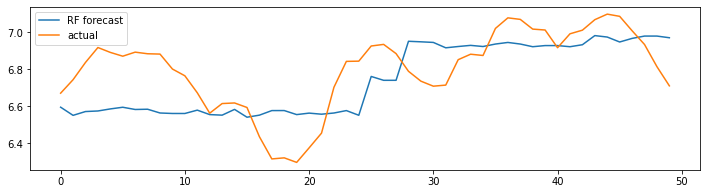

In [ ]:
# Random Forest Forecasted vs Acutal Plots
plt.figure(figsize = (12,3))
plt.plot(np.arange(50), preds, label='RF forecast')
plt.plot(np.arange(50), y_test,label='actual')
plt.legend()
plt.show()

In [ ]:
# feature importance
X = df_train.iloc[:,1:]
y = df_train.iloc[:,0]

#scaling based on range for different features 
X_std = MinMaxScaler().fit_transform(X) 
 
clf = final_RF
predictor = clf.fit(X_std, y)

# feature importance
feature_importance = predictor.feature_importances_ 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

<BarContainer object of 23 artists>

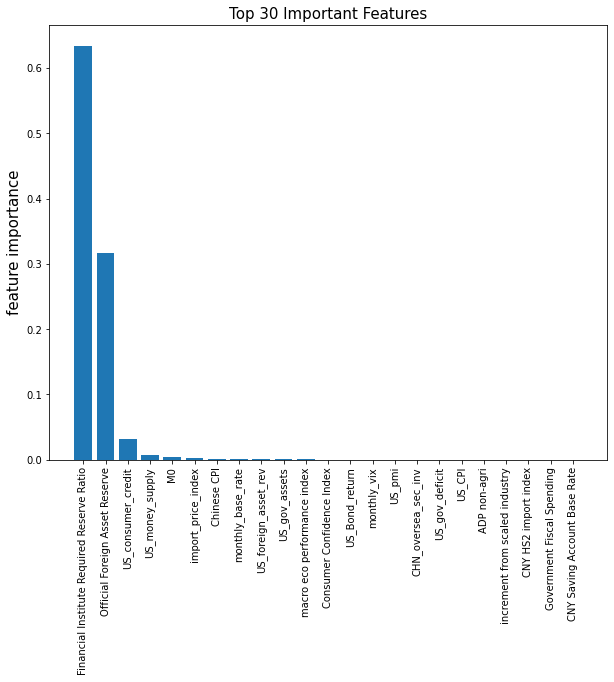

In [ ]:
Feature_name = X.columns
indices = feature_importance.argsort()[::-1][0:30]
feature_importance [[indices]]
Feature_name[[indices]]

plt.figure(figsize=(10,8))
plt.title('Top 30 Important Features',fontsize = 15)
plt.ylabel('feature importance',fontsize = 15)
plt.xticks(rotation = 90)
plt.bar(Feature_name[[indices]],feature_importance[[indices]])

#### **Xgboost**

In [ ]:
# set up all the parameters
n_estimators = [10,50,200,300] 
learning_rate = [0.1,0.5,1]  
max_depth = [50,100,200]  
min_child_weight = [4,6,10]
subsample = [0.1,0.9,0.3,0.7] 
colsample_bytree = [ 0.2,0.6,0.8] 
gamma = [0.1,0.2]
reg_alpha = [0.1,0.01,0.05,1,4]  
reg_lambda = [0.01,0.05,1,0.5,1,4] 

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate,
                  max_depth=max_depth, min_child_weight=min_child_weight,
                  reg_alpha=reg_alpha,subsample=subsample,gamma=gamma,
                  colsample_bytree=colsample_bytree,reg_lambda=reg_lambda)

XGB = XGBRegressor()
grid = GridSearchCV(estimator = XGB, param_grid = param_grid, 
                    scoring = 'neg_mean_absolute_error', verbose = 0, n_jobs = -1, cv = 5)

In [ ]:
#result = grid.fit(x_train,y_train)
#print('best score:', result.best_score_)
#print('best parameters:', result.best_params_)

In [ ]:
final_xgb = XGBRegressor(n_estimators=50, learning_rate=0.5, max_depth=50, 
                         min_child_weight=8,gamma=0.1,reg_alpha=1, reg_lambda=1,
                         colsample_bytree= 0.2, subsample=0.3).fit(x_train,y_train)                      
xgb_pre = final_xgb.predict(x_test)

[08:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_valid = y_test
preds = xgb_pre
SMAPE = (100/len(y_valid)) * np.sum(2 * np.abs(preds - y_valid) / (np.abs(y_valid) + np.abs(preds)))
print("the symmetric mean absolute percentage error is", round(SMAPE,3),"%")

the symmetric mean absolute percentage error is 6.328 %


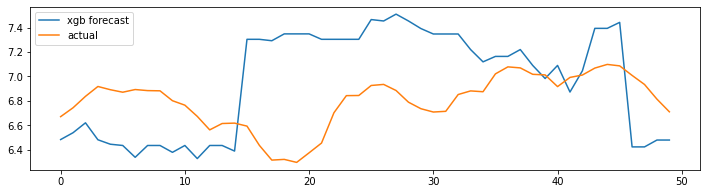

In [ ]:
# Random Forest Forecasted vs Acutal Plots
plt.figure(figsize = (12,3))
plt.plot(np.arange(50), xgb_pre, label='xgb forecast')
plt.plot(np.arange(50), y_test,label='actual')
plt.legend()
plt.show()

In [ ]:
# feature importance
X = df_train.iloc[:,1:]
y = df_train.iloc[:,0]

#scaling based on range for different features 
X_std = MinMaxScaler().fit_transform(X) 
 
clf = final_xgb
predictor = clf.fit(X_std, y)

# feature importance
feature_importance = predictor.feature_importances_ 

[08:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

<BarContainer object of 23 artists>

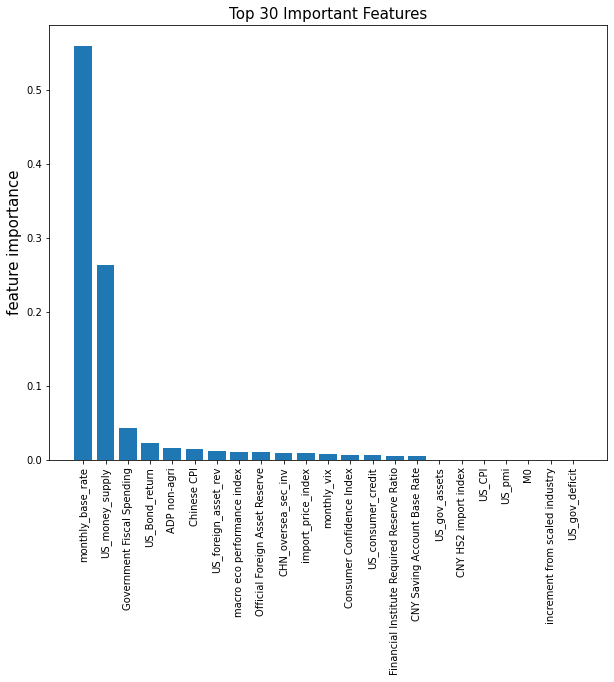

In [ ]:
Feature_name = X.columns
indices = feature_importance.argsort()[::-1][0:30]
feature_importance [[indices]]
Feature_name[[indices]]

plt.figure(figsize=(10,8))
plt.title('Top 30 Important Features',fontsize = 15)
plt.ylabel('feature importance',fontsize = 15)
plt.xticks(rotation = 90)
plt.bar(Feature_name[[indices]],feature_importance[[indices]])

## **Micro Factors**

#### 1年中债国债到期收益率

In [ ]:
df_CNY_1_yr_bond = pd.read_excel('1yr中债国债到期收益率(中债)(日).xls', names=['Date','1_yr_AAA_CNY_govern_bond'])  
df_CNY_1_yr_bond = df_CNY_1_yr_bond.iloc[1995:,:].reset_index().drop(["index"], axis = 1)
df_CNY_1_yr_bond

,Date,1_yr_AAA_CNY_govern_bond
0,2010-01-04,1.5000
1,2010-01-05,1.5098
2,2010-01-06,1.5238
3,2010-01-07,1.5489
4,2010-01-08,1.5411
...,...,...
2742,2020-12-21,2.6919
2743,2020-12-22,2.6695
2744,2020-12-23,2.6551
2745,2020-12-24,2.6501


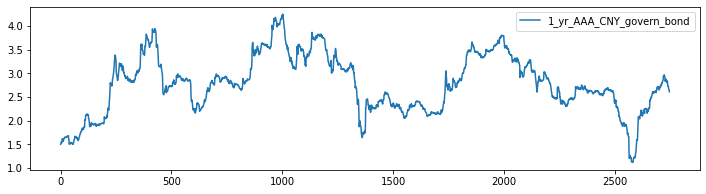

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_CNY_1_yr_bond.shape[0]), np.array(df_CNY_1_yr_bond.iloc[:,1]),
         label='1_yr_AAA_CNY_govern_bond')
plt.legend()
plt.show()

#### NASDAQ index

In [ ]:
df_NASDAQ = pd.read_excel('NASDAQ(日).xls', names=['Date','NASDAQ'])  
df_NASDAQ = df_NASDAQ.iloc[9817:,:].reset_index().drop(["index"], axis = 1)
df_NASDAQ

,Date,NASDAQ
0,2010-01-06,2301.09
1,2010-01-07,2300.05
2,2010-01-08,2317.17
3,2010-01-11,2312.41
4,2010-01-12,2282.31
...,...,...
2758,2020-12-18,12755.64
2759,2020-12-21,12742.52
2760,2020-12-22,12807.92
2761,2020-12-23,12771.11


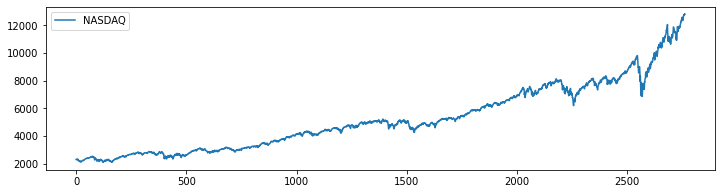

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_NASDAQ.shape[0]), np.array(df_NASDAQ.iloc[:,1]),label='NASDAQ')
plt.legend()
plt.show()

#### **QDII 投资额度**

In [ ]:
#df_QDII_scale = pd.read_excel('QDII投资额度.xls', names=['Date','QDII_scale'])  
#df_QDII_scale = df_QDII_scale.iloc[14:,:].reset_index().drop(["index"], axis = 1)
#df_QDII_scale

In [ ]:
#plt.figure(figsize = (12,3))
#plt.plot(np.arange(df_QDII_scale.shape[0]), np.array(df_QDII_scale.iloc[:,1]),label='QDII scale')
#plt.legend()
#plt.show()

#### SP500主要指数(日)

In [ ]:
df_sp500 = pd.read_excel('sp500主要指数(日).xls', names=['Date','sp500'])  
df_sp500 = df_sp500.iloc[20598:,:].reset_index().drop(["index"], axis = 1)
df_sp500

,Date,sp500
0,2010-01-06,1137.14
1,2010-01-07,1141.69
2,2010-01-08,1144.98
3,2010-01-11,1146.98
4,2010-01-12,1136.22
...,...,...
2758,2020-12-18,3709.41
2759,2020-12-21,3694.92
2760,2020-12-22,3687.26
2761,2020-12-23,3690.01


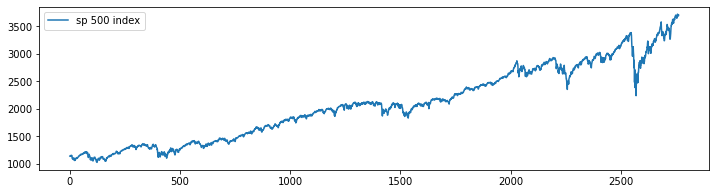

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_sp500.shape[0]), np.array(df_sp500.iloc[:,1]),label='sp 500 index')
plt.legend()
plt.show()

#### USD Libor

In [ ]:
df_usd_libor = pd.read_excel('USD伦敦同业拆借利率(LIBOR)(日).xls', names=['Date','USD_LIBOR'])  
df_usd_libor = df_usd_libor.iloc[2214:,:].reset_index().drop(["index"], axis = 1)
df_usd_libor

,Date,USD_LIBOR
0,2010-01-06,0.17500
1,2010-01-07,0.17500
2,2010-01-08,0.17313
3,2010-01-11,0.17313
4,2010-01-12,0.17313
...,...,...
2699,2020-12-18,0.08438
2700,2020-12-21,0.08463
2701,2020-12-22,0.08513
2702,2020-12-23,0.08563


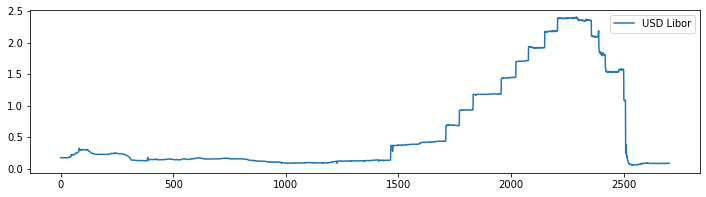

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_usd_libor.shape[0]), np.array(df_usd_libor.iloc[:,1]),label='USD Libor')
plt.legend()
plt.show()

#### SHIBOR rate

In [ ]:
df_shibor = pd.read_excel('上海银行间同业拆放利率(SHIBOR)(日).xls', names=['Date','Shibor'])  
df_shibor = df_shibor.iloc[14:,:].reset_index().drop(["index"], axis = 1)
df_shibor

,Date,Shibor
0,2006-10-27,2.1568
1,2006-10-30,2.1600
2,2006-10-31,2.1885
3,2006-11-01,2.2023
4,2006-11-02,2.2057
...,...,...
3535,2020-12-21,1.4890
3536,2020-12-22,1.0150
3537,2020-12-23,0.6230
3538,2020-12-24,0.6090


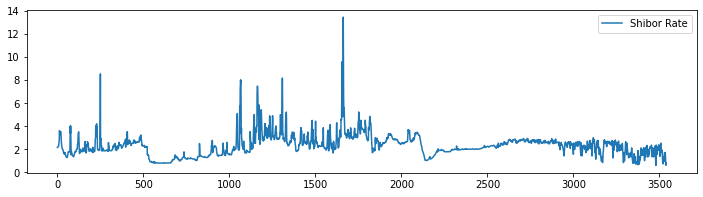

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_shibor.shape[0]), np.array(df_shibor.iloc[:,1]),label='Shibor Rate')
plt.legend()
plt.show()

#### 中债国开债到期收益率(中债)(日)

In [ ]:
df_CDB_bond = pd.read_excel('中债国开债到期收益率(中债)(日).xls', names=['Date','1_yr_CDB'])  
df_CDB_bond = df_CDB_bond.iloc[1991:,:].reset_index().drop(["index"], axis = 1)
df_CDB_bond

,Date,1_yr_CDB
0,2010-01-04,2.2068
1,2010-01-05,2.2104
2,2010-01-06,2.1969
3,2010-01-07,2.1940
4,2010-01-08,2.2208
...,...,...
2742,2020-12-21,2.7877
2743,2020-12-22,2.7615
2744,2020-12-23,2.7517
2745,2020-12-24,2.7455


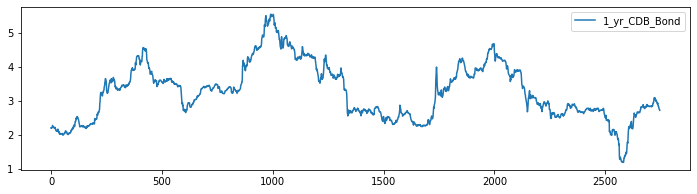

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_CDB_bond.shape[0]), np.array(df_CDB_bond.iloc[:,1]),label='1_yr_CDB_Bond')
plt.legend()
plt.show()

#### USD/CNY 即期汇率（1D）(not used)

In [ ]:
#df_USDCNY_spot = pd.read_excel('USDCNY即期汇率(日).xls', names=['Date','USD/CNY_spot'])  
#df_USDCNY_spot = df_USDCNY_spot.iloc[7429:,:].reset_index().drop(["index"], axis = 1)
#df_USDCNY_spot

In [ ]:
#plt.figure(figsize = (12,3))
#plt.plot(np.arange(df_USDCNY_spot.shape[0]), np.array(df_USDCNY_spot.iloc[:,1]),label='USD/CNY spot')
#plt.legend()
#plt.show()

#### **USD/CNY远期汇率（1D**）(not used)

In [ ]:
#df_USDCNY_foward = pd.read_excel('外汇远期（1D）成交统计.xls', names=['Date','USDCNY_future'])  
#df_USDCNY_foward = df_USDCNY_foward.iloc[230:-1,:].reset_index().drop(["index"], axis = 1)
#df_USDCNY_foward

In [ ]:
#plt.figure(figsize = (12,3))
#plt.plot(np.arange(df_USDCNY_future.shape[0]), np.array(df_USDCNY_future.iloc[:,1]),label='USDCNY future')
#plt.legend()
#plt.show()

#### SP500 VIX

In [ ]:
df_sp500_vix = pd.read_excel('市场波动率指数(VIX).xls', names=['Date','sp500_vix'])  
df_sp500_vix = df_sp500_vix.iloc[5041:,:].reset_index().drop(["index"], axis = 1)
df_sp500_vix

,Date,sp500_vix
0,2010-01-06,19.16
1,2010-01-07,19.06
2,2010-01-08,18.13
3,2010-01-11,17.55
4,2010-01-12,18.25
...,...,...
2760,2020-12-18,21.57
2761,2020-12-21,25.16
2762,2020-12-22,24.23
2763,2020-12-23,23.31


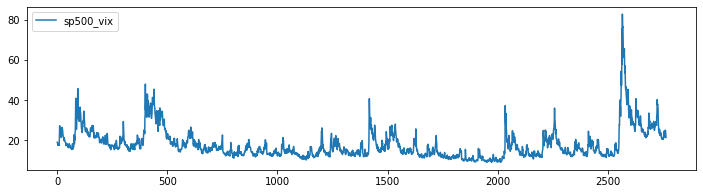

In [ ]:
plt.figure(figsize = (12,3))
plt.plot(np.arange(df_sp500_vix.shape[0]), np.array(df_sp500_vix.iloc[:,1]),label='sp500_vix')
plt.legend()
plt.show()

#### USDCNY daily fx

In [ ]:
df_daily_fx = pd.read_excel('USDCNY人民币汇率(日).xls', names=['Date','USD/CNY_daily_fx'])  
df_daily_fx = df_daily_fx.iloc[3797:,:].reset_index().drop(["index"], axis = 1)
df_daily_fx

,Date,USD/CNY_daily_fx
0,2010-01-06,6.8277
1,2010-01-07,6.8276
2,2010-01-08,6.8279
3,2010-01-11,6.8275
4,2010-01-12,6.8274
...,...,...
2663,2020-12-21,6.5507
2664,2020-12-22,6.5387
2665,2020-12-23,6.5558
2666,2020-12-24,6.5361


#### Combine all micro data

In [ ]:
df_micro = df_daily_fx.set_index('Date').join(df_CNY_1_yr_bond.set_index('Date')).join(
    df_NASDAQ.set_index('Date')).join(df_sp500.set_index('Date')).join(
        df_usd_libor.set_index('Date')).join(df_shibor.set_index('Date')).join(
            df_CDB_bond.set_index('Date')).join(df_sp500_vix.set_index('Date'))   #join(df_USDCNY_spot.set_index('Date'))

df_2 = df_micro
df_micro = df_micro.dropna().reset_index().drop(["Date"],axis = 1)

In [ ]:
df_micro

,USD/CNY_daily_fx,1_yr_AAA_CNY_govern_bond,NASDAQ,sp500,USD_LIBOR,Shibor,1_yr_CDB,sp500_vix
0,6.8277,1.5238,2301.09,1137.14,0.17500,1.1183,2.1969,19.16
1,6.8276,1.5489,2300.05,1141.69,0.17500,1.0797,2.1940,19.06
2,6.8279,1.5411,2317.17,1144.98,0.17313,1.0608,2.2208,18.13
3,6.8275,1.5330,2312.41,1146.98,0.17313,1.0471,2.2229,17.55
4,6.8274,1.5589,2282.31,1136.22,0.17313,1.0336,2.2251,18.25
...,...,...,...,...,...,...,...,...
2515,6.5315,2.7267,12755.64,3709.41,0.08438,1.7230,2.8341,21.57
2516,6.5507,2.6919,12742.52,3694.92,0.08463,1.4890,2.7877,25.16
2517,6.5387,2.6695,12807.92,3687.26,0.08513,1.0150,2.7615,24.23
2518,6.5558,2.6551,12771.11,3690.01,0.08563,0.6230,2.7517,23.31


In [ ]:
# Splitting the dataset into train & test subsets
n_obs = 2000
df_mic_train, df_mic_test = df_micro[:n_obs], df_micro[n_obs:]

### **Forecasting Model**

#### Check for stationality

In [ ]:
# Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
def adf_test(ds):
    dftest = adfuller(ds, autolag='AIC')   # one that has minimum AIC among all the other models
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")

#### First Order Differencing

In [ ]:
for i in df_micro.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_micro[i])
    print('\n')

# Differencing all variables to get rid of Stationarity
ds_differenced = df_micro.diff().dropna()

Column:  USD/CNY_daily_fx
--------------------------------------
Test Statistic            -1.741454
p-value                    0.409891
# Lags                    20.000000
# Observations          2499.000000
Critical Value (1%)       -3.432969
Critical Value (5%)       -2.862697
Critical Value (10%)      -2.567386
dtype: float64

Series is Non-Stationary


Column:  1_yr_AAA_CNY_govern_bond
--------------------------------------
Test Statistic            -3.263969
p-value                    0.016568
# Lags                    19.000000
# Observations          2500.000000
Critical Value (1%)       -3.432968
Critical Value (5%)       -2.862697
Critical Value (10%)      -2.567386
dtype: float64

Series is Stationary


Column:  NASDAQ
--------------------------------------
Test Statistic             2.172329
p-value                    0.998859
# Lags                    24.000000
# Observations          2495.000000
Critical Value (1%)       -3.432974
Critical Value (5%)       -2.862699
Criti

#### Second Order Differencing

In [ ]:
# Running the ADF test once again to test for Stationarity
for i in ds_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(ds_differenced[i])
    print('\n')

# Some features are non-stationary
ds_differenced = ds_differenced.diff().dropna()

Column:  USD/CNY_daily_fx
--------------------------------------
Test Statistic         -8.704242e+00
p-value                 3.737463e-14
# Lags                  1.900000e+01
# Observations          2.499000e+03
Critical Value (1%)    -3.432969e+00
Critical Value (5%)    -2.862697e+00
Critical Value (10%)   -2.567386e+00
dtype: float64

Series is Stationary


Column:  1_yr_AAA_CNY_govern_bond
--------------------------------------
Test Statistic         -1.583955e+01
p-value                 9.728758e-29
# Lags                  6.000000e+00
# Observations          2.512000e+03
Critical Value (1%)    -3.432956e+00
Critical Value (5%)    -2.862691e+00
Critical Value (10%)   -2.567383e+00
dtype: float64

Series is Stationary


Column:  NASDAQ
--------------------------------------
Test Statistic         -1.075966e+01
p-value                 2.539987e-19
# Lags                  2.300000e+01
# Observations          2.495000e+03
Critical Value (1%)    -3.432974e+00
Critical Value (5%)    -2.

#### **VAR model**

In [ ]:
# Fitting the VAR model to the 2nd Differenced Data
model = VAR(ds_differenced)
results = model.fit(maxlags = 5, ic = 'aic')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Jan, 2021
Time:                     08:38:23
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -16.5421
Nobs:                     2513.00    HQIC:                  -17.0267
Log likelihood:          -6457.25    FPE:                3.05814e-08
AIC:                     -17.3029    Det(Omega_mle):     2.68677e-08
--------------------------------------------------------------------
Results for equation USD/CNY_daily_fx
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.000000         0.000243           -0.002           0.999
L1.USD/CNY_daily_fx                -0.781852         0.019900          -39.289          

In [ ]:
# Forecasting for the rest 50 steps ahead
num_forcast = ds_differenced.shape[0] - 2000
predicted = results.forecast(ds_differenced.values[:2000], num_forcast)
forecast = pd.DataFrame(predicted, index = df_micro.index[:num_forcast], columns = df_micro.columns)

In [ ]:
# Inverting the Differencing Transformation
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [ ]:
forecast_values = invert_transformation(df_mic_train, forecast, second_diff=True)

In [ ]:
forecast_values.head()

,USD/CNY_daily_fx,1_yr_AAA_CNY_govern_bond,NASDAQ,sp500,USD_LIBOR,Shibor,1_yr_CDB,sp500_vix
0,6.836937,2.872980,8188.423570,2940.344508,1.922939,2.509932,3.058195,9.507599
1,6.821230,2.889627,8345.728124,2968.803206,1.919949,2.562221,3.011836,7.064544
2,6.804249,2.906245,8508.568068,3000.941068,1.923648,2.504641,2.966947,4.608951
3,6.788759,2.918236,8665.659966,3032.732465,1.926262,2.447782,2.916496,2.073001
4,6.769986,2.928007,8808.356122,3060.782018,1.925667,2.448329,2.869420,-0.233965


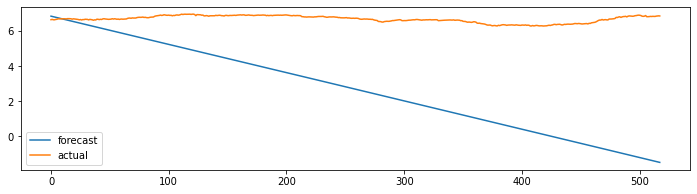

In [ ]:
# Actual vs Forecasted Plots
plt.figure(figsize = (12,3))
plt.plot(np.arange(num_forcast), np.array(forecast_values["USD/CNY_daily_fx"]),label='forecast')
plt.plot(np.arange(num_forcast), np.array(df_mic_train["USD/CNY_daily_fx"].iloc[-num_forcast:]),label='actual')
plt.legend()
plt.show()

In [ ]:
y_valid = np.array(df_mic_train["USD/CNY_daily_fx"].iloc[-num_forcast:])
preds = np.array(forecast_values["USD/CNY_daily_fx"])
SMAPE = (100/len(y_valid)) * np.sum(2 * np.abs(preds - y_valid) / (np.abs(y_valid) + np.abs(preds)))
print("the symmetric mean absolute percentage error is", round(SMAPE,3),"%")

the symmetric mean absolute percentage error is 98.028 %


In [ ]:
# feature importance
X = df_mic_train.iloc[:,1:]
y = df_mic_train.iloc[:,0]
X_std = MinMaxScaler().fit_transform(X) # scaling based on range for different features 
 
clf = RandomForestRegressor(random_state = 0, n_jobs = -1)
predictor = clf.fit(X_std, y)
feature_importance = predictor.feature_importances_ # feature importance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

<BarContainer object of 7 artists>

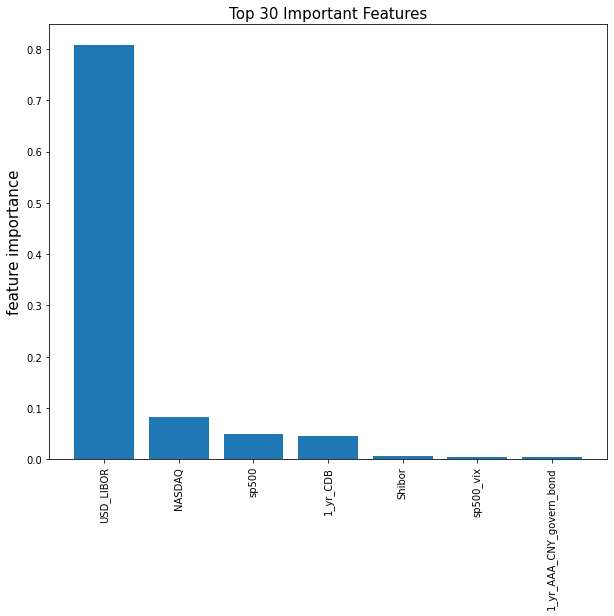

In [ ]:
Feature_name = X.columns
indices = feature_importance.argsort()[::-1][0:30]
feature_importance [[indices]]
Feature_name[[indices]]

plt.figure(figsize=(10,8))
plt.title('Top 30 Important Features',fontsize = 15)
plt.ylabel('feature importance',fontsize = 15)
plt.xticks(rotation = 90)
plt.bar(Feature_name[[indices]],feature_importance[[indices]])

#### **Decison Trees**

In [ ]:
x_train, y_train = np.array(df_mic_train.iloc[:,1:]), np.array(df_mic_train.iloc[:,0])
x_test, y_test = np.array(df_mic_test.iloc[:,1:]), np.array(df_mic_test.iloc[:,0])

In [ ]:
DS = DecisionTreeRegressor()
criterion = ['mse','mae',"poisson"]
max_depth = [25,50,100,200,1000]
splitter = ['best', 'random']
param_grid = dict(criterion = criterion, max_depth = max_depth, splitter = splitter)
grid = GridSearchCV(estimator = DS, param_grid = param_grid, scoring = 'neg_mean_absolute_error', verbose = 0, n_jobs = -1, cv = 5)

In [ ]:
#result = grid.fit(x_train,y_train)
#print('best score:', result.best_score_)
#print('best parameters:', result.best_params_)

In [ ]:
final_DS = DecisionTreeRegressor(criterion = "mae", max_depth = 25, splitter='best').fit(x_train,y_train)
DS_pre = final_DS.predict(x_test)

In [ ]:
y_valid = y_test
preds = DS_pre
SMAPE = (100/len(y_valid)) * np.sum(2 * np.abs(preds - y_valid) / (np.abs(y_valid) + np.abs(preds)))
print("the symmetric mean absolute percentage error is", round(SMAPE,3),"%")

the symmetric mean absolute percentage error is 4.235 %


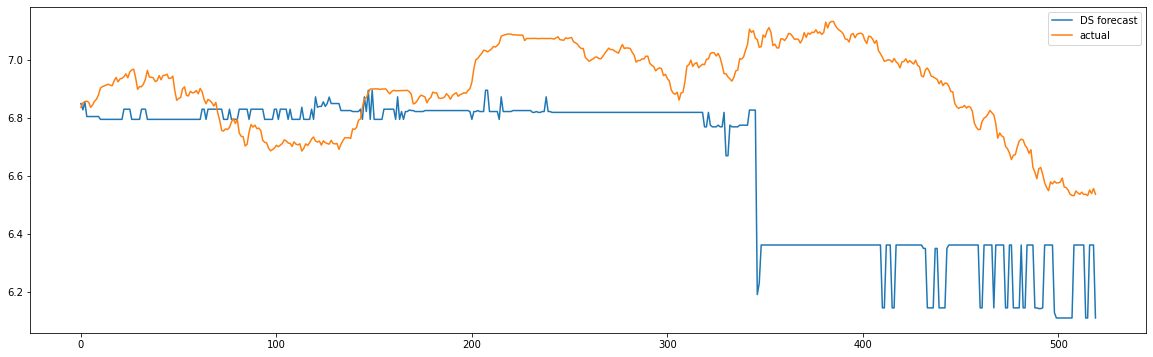

In [ ]:
# Decision Tree Forecasted vs Acutal Plots
num_forcast = df_micro.shape[0] - 2000
plt.figure(figsize = (20,6))
plt.plot(np.arange(num_forcast), DS_pre, label='DS forecast')
plt.plot(np.arange(num_forcast), y_test,label='actual')
plt.legend()
plt.show()

In [ ]:
X = df_micro.iloc[:,1:]
y = df_micro.iloc[:,0]

#scaling based on range for different features 
X_std = MinMaxScaler().fit_transform(X) 
 
clf = DecisionTreeRegressor(criterion = "mae", max_depth = 25, splitter='random')
predictor = clf.fit(X_std, y)

# feature importance
feature_importance = predictor.feature_importances_ 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

<BarContainer object of 7 artists>

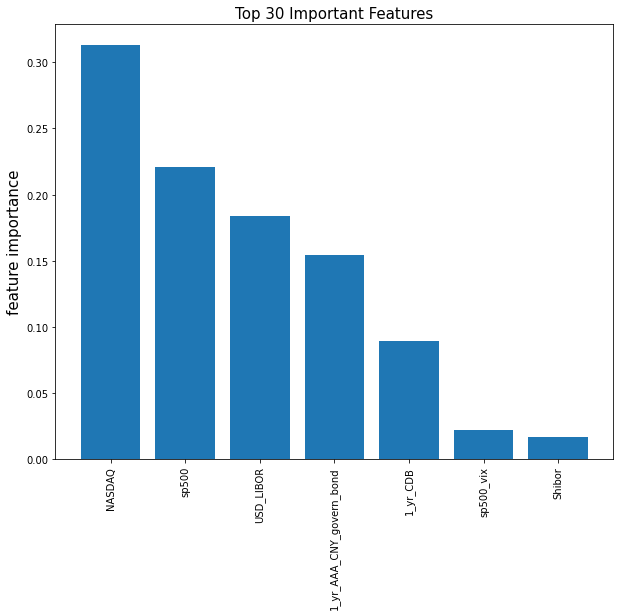

In [ ]:
Feature_name = X.columns
indices = feature_importance.argsort()[::-1][0:30]
feature_importance [[indices]]
Feature_name[[indices]]

plt.figure(figsize=(10,8))
plt.title('Top 30 Important Features',fontsize = 15)
plt.ylabel('feature importance',fontsize = 15)
plt.xticks(rotation = 90)
plt.bar(Feature_name[[indices]],feature_importance[[indices]])

#### **Random Forest**

In [ ]:
x_train, y_train = np.array(df_mic_train.iloc[:,1:]), np.array(df_mic_train.iloc[:,0])
x_test, y_test = np.array(df_mic_test.iloc[:,1:]), np.array(df_mic_test.iloc[:,0])

In [ ]:
RS = RandomForestRegressor()
n_estimators = [10,50,100,200]
max_depth = [50,100,200,500,1000]
criterion = ['mse','mae']
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,criterion = criterion)
grid = GridSearchCV(estimator = RS, param_grid = param_grid, scoring = 'neg_mean_absolute_error', verbose = 0, n_jobs = -1, cv = 5)

In [ ]:
#result = grid.fit(x_train,y_train)
#print('best score:', result.best_score_)
#print('best parameters:', result.best_params_)

In [ ]:
final_RF = RandomForestRegressor(criterion = "mae", max_depth = 50, n_estimators = 50).fit(x_train,y_train)
RF_pre = final_RF.predict(x_test)

In [ ]:
y_valid = y_test
preds = RF_pre
SMAPE = (100/len(y_valid)) * np.sum(2 * np.abs(preds - y_valid) / (np.abs(y_valid) + np.abs(preds)))
print("the symmetric mean absolute percentage error is", round(SMAPE,3),"%")

the symmetric mean absolute percentage error is 5.104 %


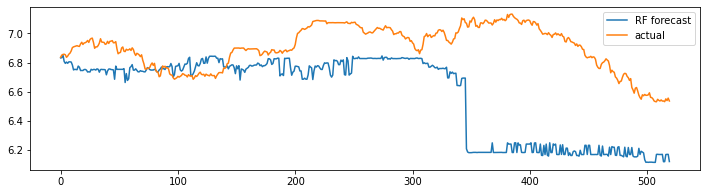

In [ ]:
# Random Forest Forecasted vs Acutal Plots
plt.figure(figsize = (12,3))
plt.plot(np.arange(RF_pre.shape[0]),RF_pre,label='RF forecast')
plt.plot(np.arange(RF_pre.shape[0]),y_test,label='actual')
plt.legend()
plt.show()

In [ ]:
# feature importance
X = df_mic_train.iloc[:,1:]
y = df_mic_train.iloc[:,0]

#scaling based on range for different features 
X_std = MinMaxScaler().fit_transform(X) 
 
clf = final_RF
predictor = clf.fit(X_std, y)

# feature importance
feature_importance = predictor.feature_importances_ 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

<BarContainer object of 7 artists>

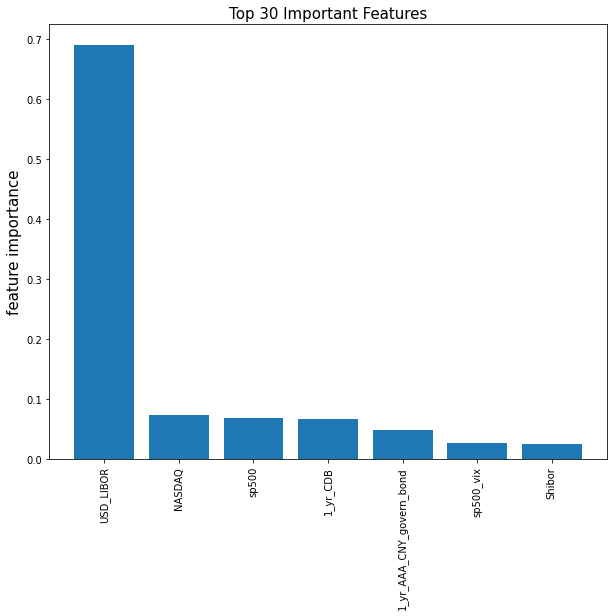

In [ ]:
Feature_name = X.columns
indices = feature_importance.argsort()[::-1][0:30]
feature_importance [[indices]]
Feature_name[[indices]]

plt.figure(figsize=(10,8))
plt.title('Top 30 Important Features',fontsize = 15)
plt.ylabel('feature importance',fontsize = 15)
plt.xticks(rotation = 90)
plt.bar(Feature_name[[indices]],feature_importance[[indices]])

#### **Xgboost**

In [ ]:
# set up all the parameters
n_estimators = [10,50,200,300] 
learning_rate = [0.1,0.2,0.5,1] 
max_depth = [50,100,200]
min_child_weight = [4,6,10]
subsample = [0.1,0.3,0.7,0.9] 
colsample_bytree = [0.2,0.6,0.8] 
gamma = [0.1,0.2]
reg_alpha = [0.01,0.05,0.1,1,4] 
reg_lambda = [0.01,0.05,0.5,1,4]

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate,
                  max_depth=max_depth, min_child_weight=min_child_weight,
                  reg_alpha=reg_alpha,subsample=subsample,gamma=gamma,
                  colsample_bytree=colsample_bytree,reg_lambda=reg_lambda)

XGB = XGBRegressor()
grid = GridSearchCV(estimator = XGB, param_grid = param_grid, scoring = 'neg_mean_absolute_error', verbose = 0, n_jobs = -1, cv = 5)

In [ ]:
#result = grid.fit(x_train,y_train)
#print('best score:', result.best_score_)
#print('best parameters:', result.best_params_)

In [ ]:
final_xgb = XGBRegressor(n_estimators=300, learning_rate=0.2, max_depth=100, 
                         min_child_weight=10,gamma=0.2,reg_alpha=0.1, reg_lambda=1,
                         colsample_bytree= 0.2, subsample=0.3).fit(x_train,y_train) 

xgb_pre = final_xgb.predict(x_test)

[08:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_valid = y_test
preds = xgb_pre
SMAPE = (100/len(y_valid)) * np.sum(2 * np.abs(preds - y_valid) / (np.abs(y_valid) + np.abs(preds)))
print("the symmetric mean absolute percentage error is", round(SMAPE,3),"%")

the symmetric mean absolute percentage error is 3.522 %


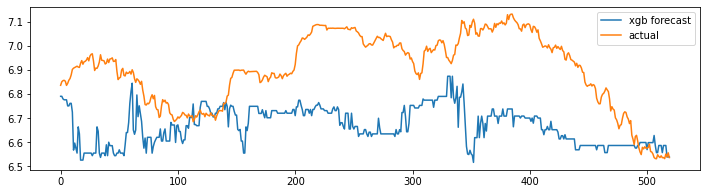

In [ ]:
# XGB Forecasted vs Acutal Plots
plt.figure(figsize = (12,3))
plt.plot(np.arange(xgb_pre.shape[0]), xgb_pre,label='xgb forecast')
plt.plot(np.arange(xgb_pre.shape[0]), y_test,label='actual')
plt.legend()
plt.show()

In [ ]:
# feature importance
X = df_mic_train.iloc[:,1:]
y = df_mic_train.iloc[:,0]

#scaling based on range for different features 
X_std = MinMaxScaler().fit_transform(X) 
 
clf = final_xgb
predictor = clf.fit(X_std, y)

# feature importance
feature_importance = predictor.feature_importances_ 

[08:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

<BarContainer object of 7 artists>

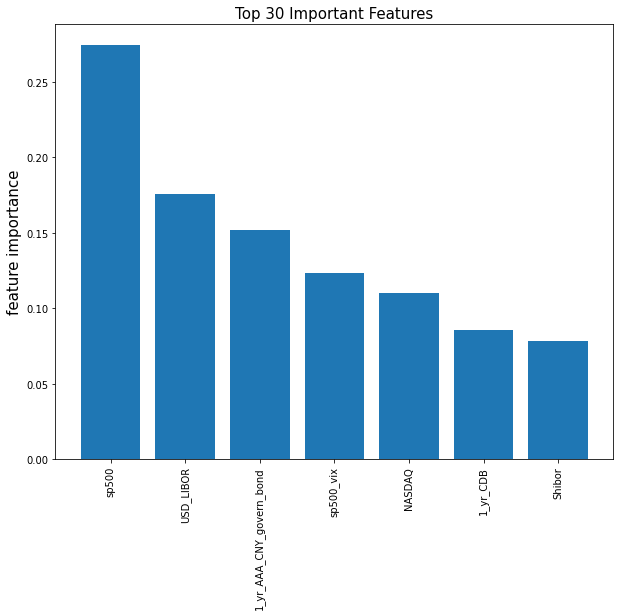

In [ ]:
Feature_name = X.columns
indices = feature_importance.argsort()[::-1][0:30]
feature_importance [[indices]]
Feature_name[[indices]]

plt.figure(figsize=(10,8))
plt.title('Top 30 Important Features',fontsize = 15)
plt.ylabel('feature importance',fontsize = 15)
plt.xticks(rotation = 90)
plt.bar(Feature_name[[indices]],feature_importance[[indices]])

## **Fianl Model: major components:Chinese per GDP, Net Foreign Assets and Term of Trade**

### per GDP

In [ ]:
# extract data for per GDP data
df_per_GDP = pd.read_excel('Per GDP.xls', names=['Date','per gdp in RMB'])
df_per_GDP = df_per_GDP.iloc[2:-1,:].reset_index().drop(["index"],axis=1).drop(["Date"],axis = 1)
df_per_GDP

,per gdp in RMB
0,2303.425041
1,1887.249563
2,2094.118016
3,2220.008305
4,2485.116786
...,...
74,17326.081211
75,18014.263776
76,19857.840791
77,14749.780365


### net foreign asset

In [ ]:
# extract data for net foreign asset
df_current_account = pd.read_excel('经常账户差额当季值(亿美元).xls', names=['Date','net foreign asset in USD']) 
df_current_account = df_current_account.iloc[10:,:].reset_index().drop(["index"],axis=1)
df_current_account
#df_BOA = pd.read_excel('国际收支总差额累计值(亿美元).xls', names=['Date','国际总收支（亿美元）']) 

,Date,net foreign asset in USD
0,2000-12-31,75.648573
1,2001-03-31,59.944197
2,2001-06-30,-8.958268
3,2001-09-30,50.046823
4,2001-12-31,73.019998
...,...,...
74,2019-06-30,305.168715
75,2019-09-30,402.137929
76,2019-12-31,405.310000
77,2020-03-31,-336.956499


### avg fx rate

In [ ]:
# avg fx rate
df_fx_2 = pd.read_excel('real_monthly_fx.xls',names=['Date',"real time fx","CNY cpi","US CPI",'real fx'])  
df_real_fx = df_fx_2.iloc[130:-5]
df_real_fx['season_real_fx'] = df_real_fx['real fx'].rolling(3, min_periods = 1).mean() 
df_real_fx = df_real_fx.iloc[::3,:]
df_real_fx = df_real_fx[['season_real_fx']].reset_index().drop(["index"],axis=1)
df_real_fx

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,season_real_fx
0,3.651662
1,1.655949
2,3.847683
3,2.448486
4,-0.690165
...,...
74,10.095283
75,11.583628
76,14.561534
77,16.950203


### term of trade

In [ ]:
# extract data for net foreign asset
df_tot = pd.read_excel('term_of_trade.xls', names=['Date','import','export','term of trade']) 
df_tot = df_tot.iloc[75:-3,:].reset_index().drop(["index"],axis=1)
df_tot['season_tot'] = df_tot['term of trade'].rolling(3, min_periods = 1).mean() 
df_tot = df_tot.iloc[::3,:]
df_tot = df_tot[["Date",'season_tot']].reset_index().drop(["index"],axis=1).drop(["Date"],axis = 1)
df_tot

,season_tot
0,0.524666
1,0.553153
2,0.510439
3,0.485379
4,0.528474
...,...
74,0.463416
75,0.543799
76,0.531069
77,0.471552


### Finalize all data

In [ ]:
# merge all tables 
df_data = pd.concat([df_real_fx,df_current_account,df_per_GDP,df_tot],axis=1)
df_data

,season_real_fx,Date,net foreign asset in USD,per gdp in RMB,season_tot
0,3.651662,2000-12-31,75.648573,2303.425041,0.524666
1,1.655949,2001-03-31,59.944197,1887.249563,0.553153
2,3.847683,2001-06-30,-8.958268,2094.118016,0.510439
3,2.448486,2001-09-30,50.046823,2220.008305,0.485379
4,-0.690165,2001-12-31,73.019998,2485.116786,0.528474
...,...,...,...,...,...
74,10.095283,2019-06-30,305.168715,17326.081211,0.463416
75,11.583628,2019-09-30,402.137929,18014.263776,0.543799
76,14.561534,2019-12-31,405.310000,19857.840791,0.531069
77,16.950203,2020-03-31,-336.956499,14749.780365,0.471552


In [ ]:
# re-organize all the data on monthly basis
df_1 = pd.concat([df_US, df_China], axis=1).iloc[11:-4]
all_date = df_1.iloc[:,0]
df_1 = df_1.drop(["Date"],axis = 1)
df_1.insert(0,'Date',value=all_date)
df_1 = df_1.rolling(3, min_periods = 1).mean() 
df_1 = df_1.iloc[::3,:].reset_index().drop(["index"],axis=1)
df_1

,US_money_supply,US_Bond_return,US_gov_assets,monthly_base_rate,US_foreign_asset_rev,monthly_vix,US_consumer_credit,US_CPI,US_gov_deficit,US_pmi,import_price_index,ADP non-agri,M0,Chinese CPI,CHN_oversea_sec_inv,increment from scaled industry,macro eco performance index,CNY HS2 import index,CNY Saving Account Base Rate,Government Fiscal Spending,Financial Institute Required Reserve Ratio,Official Foreign Asset Reserve,Consumer Confidence Index
0,1111.700000,6.830000,67647.000000,2.007037,31238.000000,26.382857,1.716970e+06,3.400000,-32666.000000,43.900000,100.500000,-25.000000,14652.650000,1.500000,1975.000000,10.400000,98.910000,101.100000,0.99,1080.860000,6.000000,1655.740000,112.900000
1,1100.466667,6.326667,66083.333333,1.749506,30210.666667,25.100794,1.746365e+06,3.366667,7483.666667,42.500000,99.566667,-78.333333,15430.333333,0.666667,9984.000000,11.133333,98.780000,101.766667,0.99,2061.036667,6.000000,1730.810000,113.100000
2,1122.566667,6.163333,64944.000000,1.745309,29223.333333,26.265397,1.782215e+06,3.366667,-64579.666667,42.400000,97.800000,-93.333333,14169.480000,1.566667,12676.666667,10.600000,99.693333,99.166667,0.99,1062.333333,6.000000,1790.053333,113.600000
3,1159.266667,5.756667,68183.666667,1.741605,30134.000000,21.718095,1.805987e+06,2.666667,13889.666667,45.333333,96.000000,-241.333333,14502.333333,0.800000,9282.666667,8.566667,100.070000,98.066667,0.99,1464.726667,6.000000,1901.030000,113.933333
4,1178.900000,5.380000,69173.000000,1.746543,29661.666667,30.704762,1.851845e+06,1.866667,11785.333333,43.400000,92.466667,-199.333333,14984.600000,-0.133333,10525.666667,8.466667,100.266667,97.366667,0.99,1431.540000,6.000000,2078.363333,113.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,3811.866667,2.733333,127523.000000,2.122469,41512.666667,14.995079,4.075594e+06,1.800000,18647.000000,52.200000,126.466667,139.666667,73115.059993,2.633333,15271.000000,5.566667,100.437667,105.233333,0.35,21636.333333,13.500000,31050.636667,124.866667
75,3860.700000,2.230000,128322.000000,2.402099,41248.000000,15.980000,4.124801e+06,1.733333,79090.333333,49.366667,125.166667,131.333333,73323.876450,2.866667,23169.333333,5.000000,99.632900,104.100000,0.35,18358.000000,13.333333,31011.013333,123.633333
76,3961.666667,2.133333,128743.000000,2.391358,41329.000000,14.446984,4.163214e+06,2.066667,118863.666667,48.066667,124.733333,212.000000,74852.898597,4.266667,16752.333333,5.933333,98.412633,102.033333,0.35,20087.333333,13.000000,31028.920000,125.166667
77,4069.133333,2.030000,128400.666667,1.902716,41201.666667,20.746190,4.198530e+06,2.100000,128953.666667,50.033333,123.600000,-6976.000000,88152.806667,4.966667,12071.000000,-10.426857,96.221633,99.566667,0.35,18115.033333,12.500000,30942.826667,122.500000


In [ ]:
# select useful index from previous predictions
df_selected = df_1[["Official Foreign Asset Reserve","M0","US_gov_deficit",
                    "US_gov_assets","Financial Institute Required Reserve Ratio",
                    "US_money_supply","US_Bond_return"]]

# merge two tables
df_3 = pd.concat([df_data, df_selected],axis = 1).drop(["Date"],axis=1).iloc[:-1]
df_3

,season_real_fx,net foreign asset in USD,per gdp in RMB,season_tot,Official Foreign Asset Reserve,M0,US_gov_deficit,US_gov_assets,Financial Institute Required Reserve Ratio,US_money_supply,US_Bond_return
0,3.651662,75.648573,2303.425041,0.524666,1655.740000,14652.650000,-32666.000000,67647.000000,6.000000,1111.700000,6.830000
1,1.655949,59.944197,1887.249563,0.553153,1730.810000,15430.333333,7483.666667,66083.333333,6.000000,1100.466667,6.326667
2,3.847683,-8.958268,2094.118016,0.510439,1790.053333,14169.480000,-64579.666667,64944.000000,6.000000,1122.566667,6.163333
3,2.448486,50.046823,2220.008305,0.485379,1901.030000,14502.333333,13889.666667,68183.666667,6.000000,1159.266667,5.756667
4,-0.690165,73.019998,2485.116786,0.528474,2078.363333,14984.600000,11785.333333,69173.000000,6.000000,1178.900000,5.380000
...,...,...,...,...,...,...,...,...,...,...,...
73,7.357413,300.741710,15627.484986,0.662037,30922.883333,80632.305390,124080.333333,125786.333333,13.500000,3733.733333,3.153333
74,10.095283,305.168715,17326.081211,0.463416,31050.636667,73115.059993,18647.000000,127523.000000,13.500000,3811.866667,2.733333
75,11.583628,402.137929,18014.263776,0.543799,31011.013333,73323.876450,79090.333333,128322.000000,13.333333,3860.700000,2.230000
76,14.561534,405.310000,19857.840791,0.531069,31028.920000,74852.898597,118863.666667,128743.000000,13.000000,3961.666667,2.133333


### Apply selected data to predict exchange rate

In [ ]:
x_train, y_train = np.array(df_3.iloc[:50,1:]), np.array(df_3.iloc[:50,0])
x_test, y_test = np.array(df_3.iloc[50:,1:]), np.array(df_3.iloc[50:,0])

In [ ]:
# set up all the parameters
n_estimators = [10,50,200,300] 
learning_rate = [0.1,0.2,0.5,1] 
max_depth = [50,100,200]
min_child_weight = [4,6,10]
subsample = [0.1,0.3,0.7,0.9] 
colsample_bytree = [0.2,0.6,0.8] 
gamma = [0.1,0.2]
reg_alpha = [0.01,0.05,0.1,1,4] 
reg_lambda = [0.01,0.05,0.5,1,4]

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate,
                  max_depth=max_depth, min_child_weight=min_child_weight,
                  reg_alpha=reg_alpha,subsample=subsample,gamma=gamma,
                  colsample_bytree=colsample_bytree,reg_lambda=reg_lambda)

XGB = XGBRegressor()
grid = GridSearchCV(estimator = XGB, param_grid = param_grid, scoring = 'neg_mean_absolute_error', verbose = 0, n_jobs = -1, cv = 5)

In [ ]:
#result = grid.fit(x_train,y_train)
#print('best score:', result.best_score_)
#print('best parameters:', result.best_params_)

In [ ]:
final_xgb = XGBRegressor(n_estimators=10, learning_rate=0.2, max_depth=100, 
                         min_child_weight= 4,gamma=0.1,reg_alpha = 4, reg_lambda = 0.01,
                         colsample_bytree= 0.6, subsample = 0.9).fit(x_train,y_train) 

xgb_pre = final_xgb.predict(x_test)

[08:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_valid = y_test
preds = xgb_pre
SMAPE = (100/len(y_valid)) * np.sum(2 * np.abs(preds - y_valid) / (np.abs(y_valid) + np.abs(preds)))
final_RMSE = mean_squared_error(y_valid, preds, squared=False)

print("the symmetric mean absolute percentage error is", round(SMAPE,3),"%")
print("the RMSE is", round(final_RMSE,3))

the symmetric mean absolute percentage error is 50.103 %
the RMSE is 12.196


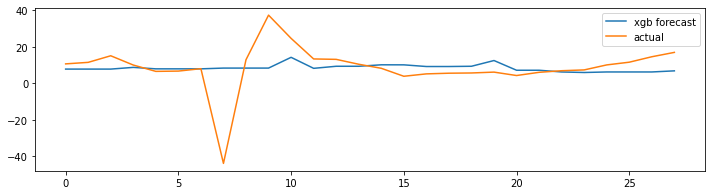

In [ ]:
# Random Forest Forecasted vs Acutal Plots
plt.figure(figsize = (12,3))
plt.plot(np.arange(xgb_pre.shape[0]), xgb_pre,label='xgb forecast')
plt.plot(np.arange(xgb_pre.shape[0]), y_test,label='actual')
plt.legend()
plt.show()

In [ ]:
# feature importance
X = df_3.iloc[:,1:]
y = df_3.iloc[:,0]

#scaling based on range for different features 
X_std = MinMaxScaler().fit_transform(X) 
 
clf = final_xgb
predictor = clf.fit(X_std, y)

# feature importance
feature_importance = predictor.feature_importances_ 

[08:39:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

<BarContainer object of 10 artists>

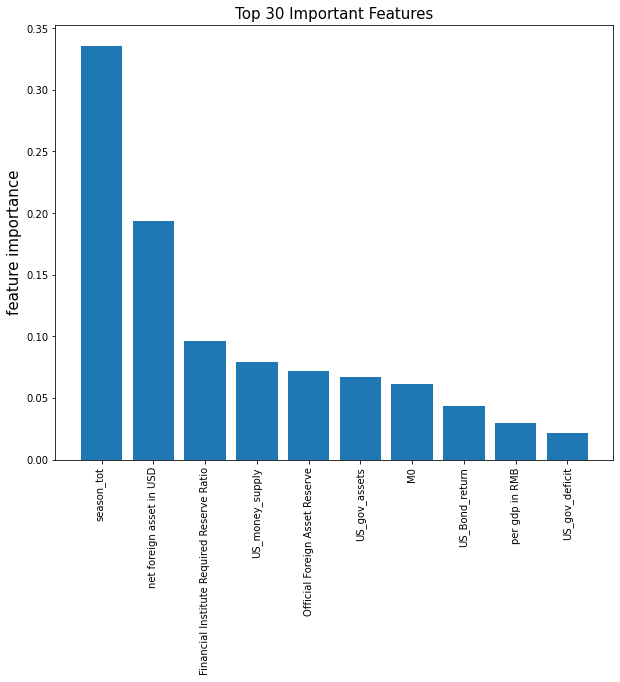

In [ ]:
Feature_name = X.columns
indices = feature_importance.argsort()[::-1][0:30]
feature_importance [[indices]]
Feature_name[[indices]]

plt.figure(figsize=(10,8))
plt.title('Top 30 Important Features',fontsize = 15)
plt.ylabel('feature importance',fontsize = 15)
plt.xticks(rotation = 90)
plt.bar(Feature_name[[indices]],feature_importance[[indices]])